# Train the Models for some/all your datasets

### First just run the cell below, it should hopefully complete without error (expect some Warnings from TF)

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2


#load some packages in
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import random as python_random
from numba import njit
from tensorboard.plugins.hparams import api as hp
from stemutils.io import Path
import hyperspy.api as hs
import concurrent.futures
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from functools import lru_cache
from stemseg.processing_funcs import *

#set some variables
print('Using TensorFlow v%s' % tf.__version__)
plt.style.use('default')


#define some functions

###################################################
########### Data Preprocessing ####################
###################################################

def batch_resize(d, bs=512):
    if len(d.shape) == 4:
        flat_d = flatten_nav(d)
    else:
        flat_d = d
    n_batches = int(np.ceil(flat_d.shape[0]//bs))
    batches = [flat_d[i*bs:(i+1)*bs] for i in range(n_batches+1)]
    if len(batches[-1])==0:
        batches.pop(-1)
    print(len(batches[-1]))
    with concurrent.futures.ProcessPoolExecutor(max_workers=4) as exe:
        res = [exe.submit(resize, batch, (batch.shape[0],128,128)) for batch in batches]
    r_batches = [f.result() for f in res]
    return np.concatenate(r_batches, axis = 0).reshape((d.shape[0],128,128))

def data_manip(d, bs = 512):
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    d = batch_resize(d, bs)
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


def data_manip_lowq(d, central_box = 128):
    pxc, pyc = d.shape[1]//2, d.shape[2]//2 
    pxl, pxu = pxc - central_box//2, pxc + central_box//2 
    pyl, pyu = pyc - central_box//2, pyc + central_box//2 
    
    d = d[:, pxl:pxu, pyl:pyu]
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 


###################################################
###################################################
###################################################

def flatten_nav(sig):
    shape = [sig.shape[0]*sig.shape[1]]
    for i in sig.shape[2:]:
        shape.append(i)
    return sig.reshape(shape)


class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, image_filenames,  batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        out_img = np.asarray([np.load(file_name)[:,:,None] for file_name in batch_x])
        return out_img, out_img
        #return batch_x, batch_y
        
        
class Array_Generator(keras.utils.Sequence) :
    def __init__(self, images,  batch_size, target = 'same') :
        self.images = images
        self.batch_size = batch_size
        if target == 'same':
            self.target = images
        else:
            self.target = target

    def __len__(self) :
        return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
    
    
    @lru_cache(None)
    def __getitem__(self, idx) :
        out_img = self.images[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        out_targ = self.target[idx * self.batch_size : (idx+1) * self.batch_size, :,:,None]
        return out_img, out_targ
        #return batch_x, batch_y

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def create_vae_model(hparams):
    
    n_img = 128
    latent_dim = hparams['LAT']
    beta = hparams['B']

    image_input = keras.Input(shape=(n_img, n_img,1), name = 'enc_input')
    x = layers.Conv2D(hparams['KN1'],5, strides = 2, activation='relu',padding='same', input_shape=image_input.shape, name = 'enc_conv1')(image_input)
    x = layers.Conv2D(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv2')(x)
    x = layers.Conv2D(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv3')(x)
    x = layers.Conv2D(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv4')(x)
    x = layers.Conv2D(hparams['KN5'],5, strides = 2, activation='relu',padding='same', name = 'enc_conv5')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(hparams['D1'], activation='relu', name = 'enc_d1')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d2_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d3_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d4_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d5_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d6_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d7_t')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'enc_d8_t')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean_t")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var_t")(x)
    z_output = Sampling()([z_mean, z_log_var])
    encoder_VAE = keras.Model(image_input, [z_mean, z_log_var, z_output])

    z_input = keras.Input(shape=(latent_dim,), name = 'dec_input_t')
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d1_t')(z_input)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d2')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d3')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d4')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d5')(x)
    x = layers.Dense(hparams['D2'], activation="relu", name = 'dec_d6')(x)
    x = layers.Dense(hparams['D1'], activation="relu", name = 'dec_d7')(x)
    x = layers.Dense(4*4*hparams['KN5'], activation="relu", name = 'dec_d8')(x)
    x = layers.Reshape((4, 4,hparams['KN5']))(x)
    x = layers.Conv2DTranspose(hparams['KN4'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv1')(x)
    x = layers.Conv2DTranspose(hparams['KN3'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv2')(x)
    x = layers.Conv2DTranspose(hparams['KN2'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv3')(x)
    x = layers.Conv2DTranspose(hparams['KN1'],5, strides = 2, activation='relu',padding='same', name = 'dec_conv4')(x)
    image_output = layers.Conv2DTranspose(1,5, strides = 2, activation='sigmoid',padding='same', name = 'dec_conv5')(x)
    #image_output = layers.Conv2DTranspose(16,3, strides = 2, activation='sigmoid',padding='same')
    #image_output = layers.Reshape((n_img, n_img,1))(x)
    decoder_VAE = keras.Model(z_input, image_output)

    # VAE class
    class VAE(keras.Model):
        # constructor
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder

        # customise train_step() to implement the loss 
        def train_step(self, x):
            if isinstance(x, tuple):
                x = x[0]
            with tf.GradientTape() as tape:
                # encoding
                z_mean, z_log_var, z = self.encoder(x)
                # decoding
                x_prime = self.decoder(z)
                # reconstruction error by binary crossentropy loss
                reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime)) * n_img * n_img
                # KL divergence
                kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                # loss = reconstruction error + KL divergence
                loss = reconstruction_loss + beta* kl_loss
            # apply gradient
            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            # return loss for metrics log
            return {"loss": loss}


        def call(self, x):
            if isinstance(x, tuple):
                x = x[0]
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            return x_prime
    # build the VAE
    vae_model = VAE(encoder_VAE, decoder_VAE)

    # compile the VAE
    vae_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hparams['LR']),loss=custom_loss)
    vae_model.build((1,128,128,1))
    
    return vae_model



def custom_loss(x,y):
    n_img = 128
    return tf.reduce_mean(keras.losses.binary_crossentropy(x, y)) * n_img * n_img


2022-04-06 11:51:27.678959: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


Using TensorFlow v2.3.0
Using TensorFlow v2.3.0


### Now check that you can find the GPU

In [2]:
tf.config.list_physical_devices()

2022-04-06 11:51:44.044857: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2022-04-06 11:51:44.045950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-04-06 11:51:44.045974: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-04-06 11:51:44.049459: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-06 11:51:44.053462: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-04-06 11:51:44.055305: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
2022-04-06 11:51:44.057973: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcusolv

# Training a Single Dataset

### Either enter the path directly to the dp variable or use the index from the list above

In [3]:
#Either
dp = Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/20210925_152115_data.hdf5')

### Create a directory to save our intermediate model checkpoints 

In [4]:
mp = Path('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel')
if not mp.exists():
    mp.mkdir()
print(mp)

/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel


### Load in the Data

In [5]:
sample = ProcessedSample(dp, 'Test')

### Create a dictionary to hold some useful information

In [6]:
info = {}

In [7]:
nds = flatten_nav(sample.raw_data.data)

In [8]:
nds.shape

(65025, 476, 476)

In [9]:
ds = hs.load(dp)

In [10]:
#flat_dps = flatten_nav(ds.data)
flat_dps = nds

resample_ds = []
nl_resample_ds = []
for uind in np.unique(flat_bm):
    print(uind)
    pdf = np.where(flat_bm ==uind, 1, 0)
    npdf = pdf/pdf.sum()
    for i in range(10):
        sdps = hs.signals.Signal2D(flat_dps[np.random.choice(np.arange(flat_dps.shape[0]), nsamples, False, npdf)])
        pn_dps = sdps.copy()
        nl_resample_ds.append(sdps.data)
        pn_dps.add_poissonian_noise()
        resample_ds.append(pn_dps)

np.random.shuffle(nl_resample_ds)

In [12]:
def data_manip_lowq_resized(d, central_box = 256, bs = 256):
    pxc, pyc = d.shape[1]//2, d.shape[2]//2 
    pxl, pxu = pxc - central_box//2, pxc + central_box//2 
    pyl, pyu = pyc - central_box//2, pyc + central_box//2 
    
    d = d[:, pxl:pxu, pyl:pyu]
    if type(d) != np.ndarray:
        print('dask to numpy')
        d = d.compute()
        print('dask to numpy done')
    print('started data manipulations')
    #d = resize(d,(d.shape[0],128,128))
    print('resized')
    d = d.astype('float32')
    for i in range(d.shape[0]):
        d_max = np.max(d[i])
        d[i] = d[i]/d_max
    d = batch_resize(d, bs)
    scaler = np.log(1001)
    return np.log((d*1000)+1)/scaler 

In [13]:
input_data = data_manip_lowq_resized(flat_dps)
#np.random.shuffle(input_data)
#input_targets = data_manip_lowq_resized(nl_resample_ds)
val_data = data_manip_lowq_resized(flat_dps[::100])
#np.random.shuffle(val_data)


dask to numpy
dask to numpy done
started data manipulations
resized
1
dask to numpy
dask to numpy done
started data manipulations
resized
139


<IPython.core.display.Javascript object>


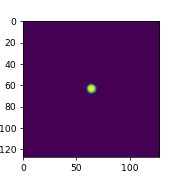

In [16]:
rand_patt = np.random.randint(0, len(input_data))
plt.figure(figsize = (4,4))
plt.imshow(input_data[rand_patt])

##### Otherwise just skip

In [17]:
print(input_data.shape)

(65025, 128, 128)


In [20]:
batch_size = 1024

train_gen = Array_Generator(input_data, batch_size)
valid_gen = Array_Generator(val_data, batch_size)

batch_shape = train_gen[0][0].shape
input_shape = (batch_shape[1],batch_shape[2],batch_shape[3])
out_dims = int(train_gen[0][1].shape[1])

### Check the training data

<IPython.core.display.Javascript object>


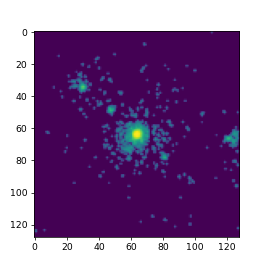

In [23]:
rand_patt = np.random.randint(0, len(input_data))
plt.figure(figsize = (4,4))
plt.imshow(input_data[rand_patt])

### Set the checkpointing

In [24]:
chkpoint_filepath = str(mp)+'/chk-{epoch:02d}-{val_loss:.5e}.hdf5'
chkpoint_model = tf.keras.callbacks.ModelCheckpoint(
    filepath = chkpoint_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
    options=None)

### Redefine the model parameters if you want

In [25]:
rebin_factor = 1

In [26]:
sample_name = 'full'
hparams= {'KN1':32,'KN2':64,'KN3':128, 'KN4':128, 'KN5':256,'D1':128,'D2':512,'LAT':2,'LR':0.0001, 'B':1}

vae_model = create_vae_model(hparams)
info[sample_name] = {'rebin': rebin_factor, 'hparams':hparams}

2022-04-06 11:58:12.373886: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-06 11:58:12.388580: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2400000000 Hz
2022-04-06 11:58:12.393536: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fb8ad953e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-06 11:58:12.393562: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-04-06 11:58:12.500659: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fb8aeda970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-04-06 11:58:12.

### Will be helpful to start with a trained model so set one here (otherwise will just take longer)

In [27]:
old_model_path ='/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-572-1.35383e+03.hdf5'

In [28]:
old_model = create_vae_model(hparams)
old_model.load_weights(old_model_path)

In [29]:
def transfer_layer_weights(old_model, new_model, enc_layer_list, dec_layer_list):
    for l in enc_layer_list:
        w = old_model.get_layer(index = 0).get_layer(index=l).get_weights()
        new_model.get_layer(index = 0).get_layer(index=l).set_weights(w)

    for l in dec_layer_list:
        w = old_model.get_layer(index = 1).get_layer(index=l).get_weights()
        new_model.get_layer(index = 1).get_layer(index=l).set_weights(w)
    return new_model

In [30]:
old_model.encoder.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
enc_conv1 (Conv2D)              (None, 64, 64, 32)   832         enc_input[0][0]                  
__________________________________________________________________________________________________
enc_conv2 (Conv2D)              (None, 32, 32, 64)   51264       enc_conv1[0][0]                  
__________________________________________________________________________________________________
enc_conv3 (Conv2D)              (None, 16, 16, 128)  204928      enc_conv2[0][0]                  
_______________________________________________________________________________________

In [31]:
enc_layer_list = list(range(7))

In [32]:
old_model.decoder.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dec_input_t (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dec_d1_t (Dense)             (None, 512)               1536      
_________________________________________________________________
dec_d2 (Dense)               (None, 512)               262656    
_________________________________________________________________
dec_d3 (Dense)               (None, 512)               262656    
_________________________________________________________________
dec_d4 (Dense)               (None, 512)               262656    
_________________________________________________________________
dec_d5 (Dense)               (None, 512)               262656    
_________________________________________________________________
dec_d6 (Dense)               (None, 512)              

In [33]:
dec_layer_list = list(range(9,14))

In [34]:
vae_model = transfer_layer_weights(old_model, vae_model, enc_layer_list, dec_layer_list)

### Train the Model

In [35]:
history = vae_model.fit(train_gen,validation_data=valid_gen, epochs=10000, callbacks= [chkpoint_model])

Epoch 1/10000


2022-04-06 11:58:44.222070: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-06 11:58:44.469130: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-04-06 11:58:45.499927: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2022-04-06 11:58:45.651788: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


64/64 [==============================] - ETA: 0s - loss: 2821.1759
Epoch 00001: val_loss improved from inf to 933.31232, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-01-9.33312e+02.hdf5
64/64 [==============================] - 50s 787ms/step - loss: 2791.9888 - val_loss: 933.3123
Epoch 2/10000
64/64 [==============================] - ETA: 0s - loss: 856.8382
Epoch 00002: val_loss improved from 933.31232 to 811.57104, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-02-8.11571e+02.hdf5
64/64 [==============================] - 17s 266ms/step - loss: 860.2991 - val_loss: 811.5710
Epoch 3/10000
64/64 [==============================] - ETA: 0s - loss: 771.3573
Epoch 00003: val_loss improved from 811.57104 to 744.94482, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-03-7.44945e+02.hdf5
64/64 [==========

64/64 [==============================] - ETA: 0s - loss: 698.2753
Epoch 00026: val_loss improved from 697.72913 to 695.66284, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-26-6.95663e+02.hdf5
64/64 [==============================] - 17s 263ms/step - loss: 690.0770 - val_loss: 695.6628
Epoch 27/10000
64/64 [==============================] - ETA: 0s - loss: 692.5327
Epoch 00027: val_loss improved from 695.66284 to 692.18848, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-27-6.92188e+02.hdf5
64/64 [==============================] - 17s 263ms/step - loss: 700.0817 - val_loss: 692.1885
Epoch 28/10000
64/64 [==============================] - ETA: 0s - loss: 691.1149
Epoch 00028: val_loss did not improve from 692.18848
64/64 [==============================] - 17s 260ms/step - loss: 683.0134 - val_loss: 693.2695
Epoch 29/10000
64/64 [==============================] -

Epoch 53/10000
64/64 [==============================] - ETA: 0s - loss: 678.2619
Epoch 00053: val_loss improved from 679.69287 to 678.83612, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-53-6.78836e+02.hdf5
64/64 [==============================] - 17s 264ms/step - loss: 668.9968 - val_loss: 678.8361
Epoch 54/10000
64/64 [==============================] - ETA: 0s - loss: 681.3450
Epoch 00054: val_loss did not improve from 678.83612
64/64 [==============================] - 17s 260ms/step - loss: 687.5312 - val_loss: 690.6068
Epoch 55/10000
64/64 [==============================] - ETA: 0s - loss: 686.1192
Epoch 00055: val_loss did not improve from 678.83612
64/64 [==============================] - 17s 260ms/step - loss: 677.1828 - val_loss: 679.7683
Epoch 56/10000
64/64 [==============================] - ETA: 0s - loss: 679.5017
Epoch 00056: val_loss improved from 678.83612 to 678.65369, saving model to /dls/science/groups/i

Epoch 82/10000
64/64 [==============================] - ETA: 0s - loss: 674.3371
Epoch 00082: val_loss did not improve from 671.40637
64/64 [==============================] - 17s 262ms/step - loss: 677.4871 - val_loss: 671.9391
Epoch 83/10000
64/64 [==============================] - ETA: 0s - loss: 672.3153
Epoch 00083: val_loss improved from 671.40637 to 670.95605, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-83-6.70956e+02.hdf5
64/64 [==============================] - 17s 264ms/step - loss: 679.2244 - val_loss: 670.9561
Epoch 84/10000
64/64 [==============================] - ETA: 0s - loss: 672.7129
Epoch 00084: val_loss did not improve from 670.95605
64/64 [==============================] - 17s 261ms/step - loss: 663.4955 - val_loss: 691.2655
Epoch 85/10000
64/64 [==============================] - ETA: 0s - loss: 676.1395
Epoch 00085: val_loss did not improve from 670.95605
64/64 [==============================] - 17s

64/64 [==============================] - 17s 263ms/step - loss: 658.6492 - val_loss: 667.8798
Epoch 114/10000
64/64 [==============================] - ETA: 0s - loss: 666.3353
Epoch 00114: val_loss improved from 667.87982 to 667.52692, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-114-6.67527e+02.hdf5
64/64 [==============================] - 17s 262ms/step - loss: 663.9567 - val_loss: 667.5269
Epoch 115/10000
64/64 [==============================] - ETA: 0s - loss: 666.1365
Epoch 00115: val_loss did not improve from 667.52692
64/64 [==============================] - 17s 260ms/step - loss: 671.6851 - val_loss: 667.7261
Epoch 116/10000
64/64 [==============================] - ETA: 0s - loss: 665.9117
Epoch 00116: val_loss did not improve from 667.52692
64/64 [==============================] - 17s 260ms/step - loss: 656.8234 - val_loss: 667.9039
Epoch 117/10000
64/64 [==============================] - ETA: 0s - loss: 667.105

64/64 [==============================] - 17s 262ms/step - loss: 671.4555 - val_loss: 665.8403
Epoch 147/10000
64/64 [==============================] - ETA: 0s - loss: 663.8997
Epoch 00147: val_loss improved from 665.84027 to 665.64240, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-147-6.65642e+02.hdf5
64/64 [==============================] - 17s 262ms/step - loss: 655.1137 - val_loss: 665.6424
Epoch 148/10000
64/64 [==============================] - ETA: 0s - loss: 664.9184
Epoch 00148: val_loss did not improve from 665.64240
64/64 [==============================] - 17s 260ms/step - loss: 661.8288 - val_loss: 667.7903
Epoch 149/10000
64/64 [==============================] - ETA: 0s - loss: 666.2648
Epoch 00149: val_loss did not improve from 665.64240
64/64 [==============================] - 17s 260ms/step - loss: 673.7685 - val_loss: 666.6370
Epoch 150/10000
64/64 [==============================] - ETA: 0s - loss: 664.755

64/64 [==============================] - ETA: 0s - loss: 665.3052
Epoch 00178: val_loss did not improve from 664.08319
64/64 [==============================] - 17s 260ms/step - loss: 669.6106 - val_loss: 671.0979
Epoch 179/10000
64/64 [==============================] - ETA: 0s - loss: 674.7201
Epoch 00179: val_loss did not improve from 664.08319
64/64 [==============================] - 17s 260ms/step - loss: 678.2308 - val_loss: 676.3126
Epoch 180/10000
64/64 [==============================] - ETA: 0s - loss: 673.3908
Epoch 00180: val_loss did not improve from 664.08319
64/64 [==============================] - 17s 260ms/step - loss: 665.4637 - val_loss: 667.5148
Epoch 181/10000
64/64 [==============================] - ETA: 0s - loss: 664.6892
Epoch 00181: val_loss did not improve from 664.08319
64/64 [==============================] - 17s 260ms/step - loss: 669.3804 - val_loss: 664.6047
Epoch 182/10000
64/64 [==============================] - ETA: 0s - loss: 663.0529
Epoch 00182: val_l

64/64 [==============================] - 17s 263ms/step - loss: 669.3982 - val_loss: 662.9286
Epoch 212/10000
64/64 [==============================] - ETA: 0s - loss: 661.7723
Epoch 00212: val_loss did not improve from 662.92859
64/64 [==============================] - 17s 260ms/step - loss: 661.5778 - val_loss: 663.0758
Epoch 213/10000
64/64 [==============================] - ETA: 0s - loss: 662.2464
Epoch 00213: val_loss did not improve from 662.92859
64/64 [==============================] - 17s 260ms/step - loss: 669.5276 - val_loss: 663.4005
Epoch 214/10000
64/64 [==============================] - ETA: 0s - loss: 662.0311
Epoch 00214: val_loss did not improve from 662.92859
64/64 [==============================] - 17s 260ms/step - loss: 660.8981 - val_loss: 663.6600
Epoch 215/10000
64/64 [==============================] - ETA: 0s - loss: 662.0071
Epoch 00215: val_loss did not improve from 662.92859
64/64 [==============================] - 17s 260ms/step - loss: 664.8996 - val_loss:

Epoch 244/10000
64/64 [==============================] - ETA: 0s - loss: 660.2945
Epoch 00244: val_loss did not improve from 661.56439
64/64 [==============================] - 17s 260ms/step - loss: 651.7168 - val_loss: 662.9794
Epoch 245/10000
64/64 [==============================] - ETA: 0s - loss: 660.9419
Epoch 00245: val_loss did not improve from 661.56439
64/64 [==============================] - 17s 260ms/step - loss: 668.2447 - val_loss: 661.6545
Epoch 246/10000
64/64 [==============================] - ETA: 0s - loss: 664.0226
Epoch 00246: val_loss did not improve from 661.56439
64/64 [==============================] - 17s 260ms/step - loss: 671.4075 - val_loss: 673.6277
Epoch 247/10000
64/64 [==============================] - ETA: 0s - loss: 669.1049
Epoch 00247: val_loss did not improve from 661.56439
64/64 [==============================] - 17s 260ms/step - loss: 676.0495 - val_loss: 666.3016
Epoch 248/10000
64/64 [==============================] - ETA: 0s - loss: 667.1563
Ep

64/64 [==============================] - ETA: 0s - loss: 659.9079
Epoch 00277: val_loss did not improve from 660.59827
64/64 [==============================] - 17s 260ms/step - loss: 658.7122 - val_loss: 660.9475
Epoch 278/10000
64/64 [==============================] - ETA: 0s - loss: 660.4048
Epoch 00278: val_loss did not improve from 660.59827
64/64 [==============================] - 17s 260ms/step - loss: 659.2369 - val_loss: 665.3044
Epoch 279/10000
64/64 [==============================] - ETA: 0s - loss: 674.2085
Epoch 00279: val_loss did not improve from 660.59827
64/64 [==============================] - 17s 260ms/step - loss: 666.3037 - val_loss: 675.2647
Epoch 280/10000
64/64 [==============================] - ETA: 0s - loss: 670.4348
Epoch 00280: val_loss did not improve from 660.59827
64/64 [==============================] - 17s 260ms/step - loss: 675.8047 - val_loss: 662.9012
Epoch 281/10000
64/64 [==============================] - ETA: 0s - loss: 662.7266
Epoch 00281: val_l

Epoch 310/10000
64/64 [==============================] - ETA: 0s - loss: 658.7234
Epoch 00310: val_loss did not improve from 660.01154
64/64 [==============================] - 17s 260ms/step - loss: 651.9835 - val_loss: 660.0220
Epoch 311/10000
64/64 [==============================] - ETA: 0s - loss: 658.5453
Epoch 00311: val_loss improved from 660.01154 to 659.79993, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-311-6.59800e+02.hdf5
64/64 [==============================] - 17s 263ms/step - loss: 650.4999 - val_loss: 659.7999
Epoch 312/10000
64/64 [==============================] - ETA: 0s - loss: 658.8595
Epoch 00312: val_loss did not improve from 659.79993
64/64 [==============================] - 17s 260ms/step - loss: 657.6775 - val_loss: 660.8640
Epoch 313/10000
64/64 [==============================] - ETA: 0s - loss: 662.0807
Epoch 00313: val_loss did not improve from 659.79993
64/64 [==============================] 

Epoch 344/10000
64/64 [==============================] - ETA: 0s - loss: 660.9686
Epoch 00344: val_loss did not improve from 659.39142
64/64 [==============================] - 17s 260ms/step - loss: 667.7235 - val_loss: 662.0262
Epoch 345/10000
64/64 [==============================] - ETA: 0s - loss: 658.7010
Epoch 00345: val_loss did not improve from 659.39142
64/64 [==============================] - 17s 260ms/step - loss: 666.0440 - val_loss: 659.5086
Epoch 346/10000
64/64 [==============================] - ETA: 0s - loss: 657.9480
Epoch 00346: val_loss improved from 659.39142 to 659.29126, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-346-6.59291e+02.hdf5
64/64 [==============================] - 17s 263ms/step - loss: 654.8813 - val_loss: 659.2913
Epoch 347/10000
64/64 [==============================] - ETA: 0s - loss: 658.0716
Epoch 00347: val_loss did not improve from 659.29126
64/64 [==============================] 

Epoch 377/10000
64/64 [==============================] - ETA: 0s - loss: 659.6687
Epoch 00377: val_loss did not improve from 658.80701
64/64 [==============================] - 17s 260ms/step - loss: 655.6932 - val_loss: 661.3760
Epoch 378/10000
64/64 [==============================] - ETA: 0s - loss: 659.8623
Epoch 00378: val_loss did not improve from 658.80701
64/64 [==============================] - 17s 260ms/step - loss: 666.8349 - val_loss: 659.9828
Epoch 379/10000
64/64 [==============================] - ETA: 0s - loss: 663.0259
Epoch 00379: val_loss did not improve from 658.80701
64/64 [==============================] - 17s 260ms/step - loss: 669.9817 - val_loss: 661.9255
Epoch 380/10000
64/64 [==============================] - ETA: 0s - loss: 661.3156
Epoch 00380: val_loss did not improve from 658.80701
64/64 [==============================] - 17s 260ms/step - loss: 668.7226 - val_loss: 663.3431
Epoch 381/10000
64/64 [==============================] - ETA: 0s - loss: 659.2211
Ep

64/64 [==============================] - ETA: 0s - loss: 660.6457
Epoch 00410: val_loss did not improve from 658.28375
64/64 [==============================] - 17s 260ms/step - loss: 658.2768 - val_loss: 661.1378
Epoch 411/10000
64/64 [==============================] - ETA: 0s - loss: 661.4575
Epoch 00411: val_loss did not improve from 658.28375
64/64 [==============================] - 17s 260ms/step - loss: 668.7087 - val_loss: 661.4974
Epoch 412/10000
64/64 [==============================] - ETA: 0s - loss: 658.8797
Epoch 00412: val_loss did not improve from 658.28375
64/64 [==============================] - 17s 260ms/step - loss: 650.2228 - val_loss: 662.5154
Epoch 413/10000
64/64 [==============================] - ETA: 0s - loss: 661.7854
Epoch 00413: val_loss did not improve from 658.28375
64/64 [==============================] - 17s 260ms/step - loss: 669.0592 - val_loss: 661.2575
Epoch 414/10000
64/64 [==============================] - ETA: 0s - loss: 659.7259
Epoch 00414: val_l

Epoch 445/10000
64/64 [==============================] - ETA: 0s - loss: 657.3610
Epoch 00445: val_loss did not improve from 658.10376
64/64 [==============================] - 17s 260ms/step - loss: 660.4069 - val_loss: 659.0623
Epoch 446/10000
64/64 [==============================] - ETA: 0s - loss: 658.4564
Epoch 00446: val_loss did not improve from 658.10376
64/64 [==============================] - 17s 260ms/step - loss: 656.1450 - val_loss: 665.2266
Epoch 447/10000
64/64 [==============================] - ETA: 0s - loss: 658.9455
Epoch 00447: val_loss did not improve from 658.10376
64/64 [==============================] - 17s 260ms/step - loss: 652.2021 - val_loss: 660.8638
Epoch 448/10000
64/64 [==============================] - ETA: 0s - loss: 658.7089
Epoch 00448: val_loss did not improve from 658.10376
64/64 [==============================] - 17s 260ms/step - loss: 649.6840 - val_loss: 658.7596
Epoch 449/10000
64/64 [==============================] - ETA: 0s - loss: 657.5171
Ep

Epoch 478/10000
64/64 [==============================] - ETA: 0s - loss: 657.0730
Epoch 00478: val_loss did not improve from 657.29150
64/64 [==============================] - 17s 262ms/step - loss: 660.5768 - val_loss: 658.1461
Epoch 479/10000
64/64 [==============================] - ETA: 0s - loss: 656.3696
Epoch 00479: val_loss did not improve from 657.29150
64/64 [==============================] - 17s 260ms/step - loss: 663.6319 - val_loss: 657.6716
Epoch 480/10000
64/64 [==============================] - ETA: 0s - loss: 657.6986
Epoch 00480: val_loss did not improve from 657.29150
64/64 [==============================] - 17s 260ms/step - loss: 665.0491 - val_loss: 661.9223
Epoch 481/10000
64/64 [==============================] - ETA: 0s - loss: 661.1703
Epoch 00481: val_loss did not improve from 657.29150
64/64 [==============================] - 17s 260ms/step - loss: 654.4052 - val_loss: 661.5635
Epoch 482/10000
64/64 [==============================] - ETA: 0s - loss: 658.8411
Ep

Epoch 514/10000
64/64 [==============================] - ETA: 0s - loss: 658.0741
Epoch 00514: val_loss did not improve from 657.29150
64/64 [==============================] - 17s 260ms/step - loss: 660.8373 - val_loss: 659.6700
Epoch 515/10000
64/64 [==============================] - ETA: 0s - loss: 656.8297
Epoch 00515: val_loss did not improve from 657.29150
64/64 [==============================] - 17s 260ms/step - loss: 664.0757 - val_loss: 658.1464
Epoch 516/10000
64/64 [==============================] - ETA: 0s - loss: 656.1182
Epoch 00516: val_loss did not improve from 657.29150
64/64 [==============================] - 17s 260ms/step - loss: 654.9464 - val_loss: 657.5169
Epoch 517/10000
64/64 [==============================] - ETA: 0s - loss: 655.8533
Epoch 00517: val_loss did not improve from 657.29150
64/64 [==============================] - 17s 260ms/step - loss: 661.2511 - val_loss: 657.3405
Epoch 518/10000
64/64 [==============================] - ETA: 0s - loss: 656.9633
Ep

64/64 [==============================] - 17s 263ms/step - loss: 659.1649 - val_loss: 656.8661
Epoch 547/10000
64/64 [==============================] - ETA: 0s - loss: 655.8607
Epoch 00547: val_loss did not improve from 656.86609
64/64 [==============================] - 17s 262ms/step - loss: 662.0703 - val_loss: 658.6683
Epoch 548/10000
64/64 [==============================] - ETA: 0s - loss: 656.9878
Epoch 00548: val_loss did not improve from 656.86609
64/64 [==============================] - 17s 262ms/step - loss: 660.0573 - val_loss: 658.6644
Epoch 549/10000
64/64 [==============================] - ETA: 0s - loss: 656.7281
Epoch 00549: val_loss did not improve from 656.86609
64/64 [==============================] - 17s 260ms/step - loss: 661.8275 - val_loss: 657.4156
Epoch 550/10000
64/64 [==============================] - ETA: 0s - loss: 659.6020
Epoch 00550: val_loss did not improve from 656.86609
64/64 [==============================] - 17s 260ms/step - loss: 667.0437 - val_loss:

Epoch 580/10000
64/64 [==============================] - ETA: 0s - loss: 657.2693
Epoch 00580: val_loss did not improve from 656.71686
64/64 [==============================] - 17s 260ms/step - loss: 649.2442 - val_loss: 657.6188
Epoch 581/10000
64/64 [==============================] - ETA: 0s - loss: 655.8283
Epoch 00581: val_loss did not improve from 656.71686
64/64 [==============================] - 17s 260ms/step - loss: 658.0914 - val_loss: 657.4803
Epoch 582/10000
64/64 [==============================] - ETA: 0s - loss: 655.6819
Epoch 00582: val_loss did not improve from 656.71686
64/64 [==============================] - 17s 261ms/step - loss: 660.7893 - val_loss: 657.0244
Epoch 583/10000
64/64 [==============================] - ETA: 0s - loss: 655.6767
Epoch 00583: val_loss improved from 656.71686 to 656.68683, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-583-6.56687e+02.hdf5
64/64 [==============================] 

64/64 [==============================] - ETA: 0s - loss: 655.6608
Epoch 00613: val_loss did not improve from 656.35480
64/64 [==============================] - 17s 260ms/step - loss: 658.4586 - val_loss: 657.3063
Epoch 614/10000
64/64 [==============================] - ETA: 0s - loss: 655.4878
Epoch 00614: val_loss did not improve from 656.35480
64/64 [==============================] - 17s 260ms/step - loss: 646.5527 - val_loss: 657.0684
Epoch 615/10000
64/64 [==============================] - ETA: 0s - loss: 655.0209
Epoch 00615: val_loss did not improve from 656.35480
64/64 [==============================] - 17s 260ms/step - loss: 656.0203 - val_loss: 656.3893
Epoch 616/10000
64/64 [==============================] - ETA: 0s - loss: 654.9334
Epoch 00616: val_loss did not improve from 656.35480
64/64 [==============================] - 17s 260ms/step - loss: 645.9640 - val_loss: 656.5605
Epoch 617/10000
64/64 [==============================] - ETA: 0s - loss: 654.9173
Epoch 00617: val_l

64/64 [==============================] - ETA: 0s - loss: 655.2616
Epoch 00648: val_loss did not improve from 656.12756
64/64 [==============================] - 17s 260ms/step - loss: 646.7760 - val_loss: 656.4048
Epoch 649/10000
64/64 [==============================] - ETA: 0s - loss: 654.9651
Epoch 00649: val_loss did not improve from 656.12756
64/64 [==============================] - 17s 260ms/step - loss: 655.1666 - val_loss: 656.3411
Epoch 650/10000
64/64 [==============================] - ETA: 0s - loss: 654.7826
Epoch 00650: val_loss did not improve from 656.12756
64/64 [==============================] - 17s 260ms/step - loss: 662.1059 - val_loss: 656.2339
Epoch 651/10000
64/64 [==============================] - ETA: 0s - loss: 655.0091
Epoch 00651: val_loss did not improve from 656.12756
64/64 [==============================] - 17s 260ms/step - loss: 660.3952 - val_loss: 656.1309
Epoch 652/10000
64/64 [==============================] - ETA: 0s - loss: 654.9696
Epoch 00652: val_l

Epoch 682/10000
64/64 [==============================] - ETA: 0s - loss: 657.4184
Epoch 00682: val_loss did not improve from 655.79974
64/64 [==============================] - 17s 260ms/step - loss: 661.1356 - val_loss: 659.8592
Epoch 683/10000
64/64 [==============================] - ETA: 0s - loss: 659.1127
Epoch 00683: val_loss did not improve from 655.79974
64/64 [==============================] - 17s 260ms/step - loss: 650.1244 - val_loss: 657.7382
Epoch 684/10000
64/64 [==============================] - ETA: 0s - loss: 655.9119
Epoch 00684: val_loss did not improve from 655.79974
64/64 [==============================] - 17s 260ms/step - loss: 647.0410 - val_loss: 656.6672
Epoch 685/10000
64/64 [==============================] - ETA: 0s - loss: 655.5662
Epoch 00685: val_loss did not improve from 655.79974
64/64 [==============================] - 17s 260ms/step - loss: 654.4043 - val_loss: 656.3735
Epoch 686/10000
64/64 [==============================] - ETA: 0s - loss: 654.6731
Ep

Epoch 718/10000
64/64 [==============================] - ETA: 0s - loss: 654.8520
Epoch 00718: val_loss did not improve from 655.79974
64/64 [==============================] - 17s 260ms/step - loss: 646.7743 - val_loss: 656.4452
Epoch 719/10000
64/64 [==============================] - ETA: 0s - loss: 654.4577
Epoch 00719: val_loss improved from 655.79974 to 655.73254, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-719-6.55733e+02.hdf5
64/64 [==============================] - 17s 262ms/step - loss: 652.1505 - val_loss: 655.7325
Epoch 720/10000
64/64 [==============================] - ETA: 0s - loss: 654.5266
Epoch 00720: val_loss improved from 655.73254 to 655.61316, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-720-6.55613e+02.hdf5
64/64 [==============================] - 17s 262ms/step - loss: 655.5102 - val_loss: 655.6132
Epoch 721/10000
64/64 [============

64/64 [==============================] - ETA: 0s - loss: 654.6084
Epoch 00751: val_loss did not improve from 655.22186
64/64 [==============================] - 17s 260ms/step - loss: 656.2958 - val_loss: 656.0268
Epoch 752/10000
64/64 [==============================] - ETA: 0s - loss: 655.5933
Epoch 00752: val_loss did not improve from 655.22186
64/64 [==============================] - 17s 260ms/step - loss: 662.8308 - val_loss: 655.8715
Epoch 753/10000
64/64 [==============================] - ETA: 0s - loss: 655.2324
Epoch 00753: val_loss did not improve from 655.22186
64/64 [==============================] - 17s 260ms/step - loss: 662.0766 - val_loss: 656.6844
Epoch 754/10000
64/64 [==============================] - ETA: 0s - loss: 656.6979
Epoch 00754: val_loss did not improve from 655.22186
64/64 [==============================] - 17s 260ms/step - loss: 654.9331 - val_loss: 658.4430
Epoch 755/10000
64/64 [==============================] - ETA: 0s - loss: 655.4679
Epoch 00755: val_l

64/64 [==============================] - ETA: 0s - loss: 654.0719
Epoch 00786: val_loss did not improve from 655.17096
64/64 [==============================] - 17s 260ms/step - loss: 655.0691 - val_loss: 655.5967
Epoch 787/10000
64/64 [==============================] - ETA: 0s - loss: 654.1653
Epoch 00787: val_loss did not improve from 655.17096
64/64 [==============================] - 17s 260ms/step - loss: 657.3022 - val_loss: 655.5228
Epoch 788/10000
64/64 [==============================] - ETA: 0s - loss: 654.7085
Epoch 00788: val_loss did not improve from 655.17096
64/64 [==============================] - 17s 260ms/step - loss: 662.0232 - val_loss: 655.7382
Epoch 789/10000
64/64 [==============================] - ETA: 0s - loss: 653.9259
Epoch 00789: val_loss did not improve from 655.17096
64/64 [==============================] - 17s 261ms/step - loss: 645.4359 - val_loss: 655.3701
Epoch 790/10000
64/64 [==============================] - ETA: 0s - loss: 653.7685
Epoch 00790: val_l

Epoch 821/10000
64/64 [==============================] - ETA: 0s - loss: 654.2632
Epoch 00821: val_loss did not improve from 654.96228
64/64 [==============================] - 17s 261ms/step - loss: 659.3898 - val_loss: 657.8882
Epoch 822/10000
64/64 [==============================] - ETA: 0s - loss: 654.6747
Epoch 00822: val_loss did not improve from 654.96228
64/64 [==============================] - 17s 261ms/step - loss: 661.1867 - val_loss: 655.4429
Epoch 823/10000
64/64 [==============================] - ETA: 0s - loss: 655.6953
Epoch 00823: val_loss did not improve from 654.96228
64/64 [==============================] - 17s 261ms/step - loss: 646.7453 - val_loss: 660.0873
Epoch 824/10000
64/64 [==============================] - ETA: 0s - loss: 656.6752
Epoch 00824: val_loss did not improve from 654.96228
64/64 [==============================] - 17s 260ms/step - loss: 648.0821 - val_loss: 658.6016
Epoch 825/10000
64/64 [==============================] - ETA: 0s - loss: 656.7639
Ep

Epoch 856/10000
64/64 [==============================] - ETA: 0s - loss: 653.4667
Epoch 00856: val_loss did not improve from 654.73730
64/64 [==============================] - 17s 260ms/step - loss: 644.9197 - val_loss: 654.8091
Epoch 857/10000
64/64 [==============================] - ETA: 0s - loss: 653.4031
Epoch 00857: val_loss did not improve from 654.73730
64/64 [==============================] - 17s 260ms/step - loss: 652.8037 - val_loss: 655.0021
Epoch 858/10000
64/64 [==============================] - ETA: 0s - loss: 653.9051
Epoch 00858: val_loss did not improve from 654.73730
64/64 [==============================] - 17s 260ms/step - loss: 660.6377 - val_loss: 655.5266
Epoch 859/10000
64/64 [==============================] - ETA: 0s - loss: 653.5543
Epoch 00859: val_loss did not improve from 654.73730
64/64 [==============================] - 17s 260ms/step - loss: 656.9935 - val_loss: 654.7672
Epoch 860/10000
64/64 [==============================] - ETA: 0s - loss: 653.5279
Ep

Epoch 891/10000
64/64 [==============================] - ETA: 0s - loss: 656.4350
Epoch 00891: val_loss did not improve from 654.33966
64/64 [==============================] - 17s 260ms/step - loss: 647.4881 - val_loss: 659.3340
Epoch 892/10000
64/64 [==============================] - ETA: 0s - loss: 654.9913
Epoch 00892: val_loss did not improve from 654.33966
64/64 [==============================] - 17s 260ms/step - loss: 646.4229 - val_loss: 654.8001
Epoch 893/10000
64/64 [==============================] - ETA: 0s - loss: 654.4921
Epoch 00893: val_loss did not improve from 654.33966
64/64 [==============================] - 17s 260ms/step - loss: 660.7401 - val_loss: 657.4902
Epoch 894/10000
64/64 [==============================] - ETA: 0s - loss: 654.2631
Epoch 00894: val_loss did not improve from 654.33966
64/64 [==============================] - 17s 260ms/step - loss: 661.7155 - val_loss: 655.8421
Epoch 895/10000
64/64 [==============================] - ETA: 0s - loss: 653.5449
Ep

64/64 [==============================] - ETA: 0s - loss: 653.1533
Epoch 00926: val_loss did not improve from 654.32251
64/64 [==============================] - 17s 260ms/step - loss: 659.3303 - val_loss: 654.6249
Epoch 927/10000
64/64 [==============================] - ETA: 0s - loss: 653.6198
Epoch 00927: val_loss did not improve from 654.32251
64/64 [==============================] - 17s 260ms/step - loss: 660.8481 - val_loss: 654.7683
Epoch 928/10000
64/64 [==============================] - ETA: 0s - loss: 654.4035
Epoch 00928: val_loss did not improve from 654.32251
64/64 [==============================] - 17s 260ms/step - loss: 650.3131 - val_loss: 656.1856
Epoch 929/10000
64/64 [==============================] - ETA: 0s - loss: 655.7278
Epoch 00929: val_loss did not improve from 654.32251
64/64 [==============================] - 17s 260ms/step - loss: 648.0220 - val_loss: 657.9349
Epoch 930/10000
64/64 [==============================] - ETA: 0s - loss: 656.1247
Epoch 00930: val_l

64/64 [==============================] - ETA: 0s - loss: 653.1916
Epoch 00960: val_loss did not improve from 654.06354
64/64 [==============================] - 17s 260ms/step - loss: 644.7354 - val_loss: 655.0584
Epoch 961/10000
64/64 [==============================] - ETA: 0s - loss: 653.7337
Epoch 00961: val_loss did not improve from 654.06354
64/64 [==============================] - 17s 260ms/step - loss: 650.2618 - val_loss: 654.4466
Epoch 962/10000
64/64 [==============================] - ETA: 0s - loss: 653.0381
Epoch 00962: val_loss did not improve from 654.06354
64/64 [==============================] - 17s 261ms/step - loss: 653.2315 - val_loss: 654.1988
Epoch 963/10000
64/64 [==============================] - ETA: 0s - loss: 652.8663
Epoch 00963: val_loss improved from 654.06354 to 654.00873, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-963-6.54009e+02.hdf5
64/64 [==============================] - 17s 262ms/step

Epoch 995/10000
64/64 [==============================] - ETA: 0s - loss: 653.1469
Epoch 00995: val_loss did not improve from 653.94073
64/64 [==============================] - 17s 260ms/step - loss: 649.0525 - val_loss: 654.5251
Epoch 996/10000
64/64 [==============================] - ETA: 0s - loss: 653.7677
Epoch 00996: val_loss did not improve from 653.94073
64/64 [==============================] - 17s 260ms/step - loss: 660.4959 - val_loss: 654.9657
Epoch 997/10000
64/64 [==============================] - ETA: 0s - loss: 654.1685
Epoch 00997: val_loss did not improve from 653.94073
64/64 [==============================] - 17s 260ms/step - loss: 646.1825 - val_loss: 655.6897
Epoch 998/10000
64/64 [==============================] - ETA: 0s - loss: 654.5132
Epoch 00998: val_loss did not improve from 653.94073
64/64 [==============================] - 17s 260ms/step - loss: 645.5492 - val_loss: 656.8900
Epoch 999/10000
64/64 [==============================] - ETA: 0s - loss: 655.8173
Ep

Epoch 1029/10000
64/64 [==============================] - ETA: 0s - loss: 652.7343
Epoch 01029: val_loss did not improve from 653.69214
64/64 [==============================] - 17s 260ms/step - loss: 643.8331 - val_loss: 653.9875
Epoch 1030/10000
64/64 [==============================] - ETA: 0s - loss: 653.4382
Epoch 01030: val_loss did not improve from 653.69214
64/64 [==============================] - 17s 260ms/step - loss: 656.2627 - val_loss: 656.6725
Epoch 1031/10000
64/64 [==============================] - ETA: 0s - loss: 653.6602
Epoch 01031: val_loss did not improve from 653.69214
64/64 [==============================] - 17s 260ms/step - loss: 650.5953 - val_loss: 655.3077
Epoch 1032/10000
64/64 [==============================] - ETA: 0s - loss: 653.8535
Epoch 01032: val_loss did not improve from 653.69214
64/64 [==============================] - 17s 260ms/step - loss: 644.9375 - val_loss: 655.1176
Epoch 1033/10000
64/64 [==============================] - ETA: 0s - loss: 653.33

Epoch 1063/10000
64/64 [==============================] - ETA: 0s - loss: 652.8748
Epoch 01063: val_loss did not improve from 653.51849
64/64 [==============================] - 17s 260ms/step - loss: 650.5781 - val_loss: 653.6225
Epoch 1064/10000
64/64 [==============================] - ETA: 0s - loss: 652.4749
Epoch 01064: val_loss did not improve from 653.51849
64/64 [==============================] - 17s 260ms/step - loss: 655.6319 - val_loss: 653.6854
Epoch 1065/10000
64/64 [==============================] - ETA: 0s - loss: 652.9216
Epoch 01065: val_loss did not improve from 653.51849
64/64 [==============================] - 17s 260ms/step - loss: 660.3775 - val_loss: 653.8569
Epoch 1066/10000
64/64 [==============================] - ETA: 0s - loss: 652.6645
Epoch 01066: val_loss improved from 653.51849 to 653.51099, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-1066-6.53511e+02.hdf5
64/64 [===========================

Epoch 1098/10000
64/64 [==============================] - ETA: 0s - loss: 652.4535
Epoch 01098: val_loss did not improve from 653.34363
64/64 [==============================] - 17s 260ms/step - loss: 643.5124 - val_loss: 653.7244
Epoch 1099/10000
64/64 [==============================] - ETA: 0s - loss: 652.4888
Epoch 01099: val_loss did not improve from 653.34363
64/64 [==============================] - 17s 260ms/step - loss: 658.6502 - val_loss: 654.2202
Epoch 1100/10000
64/64 [==============================] - ETA: 0s - loss: 652.9267
Epoch 01100: val_loss did not improve from 653.34363
64/64 [==============================] - 17s 260ms/step - loss: 658.7212 - val_loss: 655.3741
Epoch 1101/10000
64/64 [==============================] - ETA: 0s - loss: 654.5176
Epoch 01101: val_loss did not improve from 653.34363
64/64 [==============================] - 17s 260ms/step - loss: 659.9013 - val_loss: 657.6774
Epoch 1102/10000
64/64 [==============================] - ETA: 0s - loss: 654.42

64/64 [==============================] - ETA: 0s - loss: 653.3198
Epoch 01133: val_loss did not improve from 653.23236
64/64 [==============================] - 17s 260ms/step - loss: 660.2203 - val_loss: 654.0574
Epoch 1134/10000
64/64 [==============================] - ETA: 0s - loss: 652.3051
Epoch 01134: val_loss did not improve from 653.23236
64/64 [==============================] - 17s 260ms/step - loss: 643.8386 - val_loss: 653.4727
Epoch 1135/10000
64/64 [==============================] - ETA: 0s - loss: 652.3507
Epoch 01135: val_loss did not improve from 653.23236
64/64 [==============================] - 17s 260ms/step - loss: 657.6399 - val_loss: 653.7560
Epoch 1136/10000
64/64 [==============================] - ETA: 0s - loss: 652.7738
Epoch 01136: val_loss did not improve from 653.23236
64/64 [==============================] - 17s 260ms/step - loss: 658.1404 - val_loss: 653.4634
Epoch 1137/10000
64/64 [==============================] - ETA: 0s - loss: 652.3665
Epoch 01137: v

Epoch 1168/10000
64/64 [==============================] - ETA: 0s - loss: 652.6689
Epoch 01168: val_loss did not improve from 653.01404
64/64 [==============================] - 17s 260ms/step - loss: 644.9921 - val_loss: 657.0245
Epoch 1169/10000
64/64 [==============================] - ETA: 0s - loss: 653.5622
Epoch 01169: val_loss did not improve from 653.01404
64/64 [==============================] - 17s 260ms/step - loss: 645.0996 - val_loss: 653.5447
Epoch 1170/10000
64/64 [==============================] - ETA: 0s - loss: 652.1158
Epoch 01170: val_loss did not improve from 653.01404
64/64 [==============================] - 17s 260ms/step - loss: 643.2096 - val_loss: 653.4288
Epoch 1171/10000
64/64 [==============================] - ETA: 0s - loss: 652.0985
Epoch 01171: val_loss did not improve from 653.01404
64/64 [==============================] - 17s 260ms/step - loss: 644.0516 - val_loss: 653.3403
Epoch 1172/10000
64/64 [==============================] - ETA: 0s - loss: 652.11

64/64 [==============================] - ETA: 0s - loss: 652.1711
Epoch 01203: val_loss did not improve from 652.87280
64/64 [==============================] - 17s 260ms/step - loss: 659.4852 - val_loss: 653.3691
Epoch 1204/10000
64/64 [==============================] - ETA: 0s - loss: 652.8103
Epoch 01204: val_loss did not improve from 652.87280
64/64 [==============================] - 17s 260ms/step - loss: 652.2367 - val_loss: 654.4614
Epoch 1205/10000
64/64 [==============================] - ETA: 0s - loss: 652.2907
Epoch 01205: val_loss did not improve from 652.87280
64/64 [==============================] - 17s 260ms/step - loss: 644.3637 - val_loss: 653.1669
Epoch 1206/10000
64/64 [==============================] - ETA: 0s - loss: 652.0399
Epoch 01206: val_loss did not improve from 652.87280
64/64 [==============================] - 17s 260ms/step - loss: 659.3743 - val_loss: 653.0317
Epoch 1207/10000
64/64 [==============================] - ETA: 0s - loss: 651.8076
Epoch 01207: v

Epoch 1239/10000
64/64 [==============================] - ETA: 0s - loss: 652.3757
Epoch 01239: val_loss did not improve from 652.87280
64/64 [==============================] - 17s 261ms/step - loss: 659.8018 - val_loss: 652.9429
Epoch 1240/10000
64/64 [==============================] - ETA: 0s - loss: 652.1383
Epoch 01240: val_loss did not improve from 652.87280
64/64 [==============================] - 17s 262ms/step - loss: 643.2456 - val_loss: 653.6195
Epoch 1241/10000
64/64 [==============================] - ETA: 0s - loss: 652.9015
Epoch 01241: val_loss did not improve from 652.87280
64/64 [==============================] - 17s 262ms/step - loss: 660.1351 - val_loss: 653.6179
Epoch 1242/10000
64/64 [==============================] - ETA: 0s - loss: 652.9182
Epoch 01242: val_loss did not improve from 652.87280
64/64 [==============================] - 17s 262ms/step - loss: 656.0389 - val_loss: 654.1995
Epoch 1243/10000
64/64 [==============================] - ETA: 0s - loss: 656.88

64/64 [==============================] - ETA: 0s - loss: 652.4646
Epoch 01274: val_loss did not improve from 652.70349
64/64 [==============================] - 17s 260ms/step - loss: 645.7926 - val_loss: 654.0565
Epoch 1275/10000
64/64 [==============================] - ETA: 0s - loss: 652.1467
Epoch 01275: val_loss did not improve from 652.70349
64/64 [==============================] - 17s 260ms/step - loss: 657.5390 - val_loss: 653.9020
Epoch 1276/10000
64/64 [==============================] - ETA: 0s - loss: 652.3000
Epoch 01276: val_loss did not improve from 652.70349
64/64 [==============================] - 17s 260ms/step - loss: 655.4509 - val_loss: 653.6567
Epoch 1277/10000
64/64 [==============================] - ETA: 0s - loss: 651.7813
Epoch 01277: val_loss did not improve from 652.70349
64/64 [==============================] - 17s 260ms/step - loss: 648.3148 - val_loss: 652.9600
Epoch 1278/10000
64/64 [==============================] - ETA: 0s - loss: 651.6049
Epoch 01278: v

64/64 [==============================] - ETA: 0s - loss: 652.4050
Epoch 01309: val_loss did not improve from 652.51898
64/64 [==============================] - 17s 260ms/step - loss: 655.0904 - val_loss: 654.6345
Epoch 1310/10000
64/64 [==============================] - ETA: 0s - loss: 653.1934
Epoch 01310: val_loss did not improve from 652.51898
64/64 [==============================] - 17s 260ms/step - loss: 644.2328 - val_loss: 653.2482
Epoch 1311/10000
64/64 [==============================] - ETA: 0s - loss: 652.9345
Epoch 01311: val_loss did not improve from 652.51898
64/64 [==============================] - 17s 260ms/step - loss: 652.7028 - val_loss: 653.4222
Epoch 1312/10000
64/64 [==============================] - ETA: 0s - loss: 651.9146
Epoch 01312: val_loss did not improve from 652.51898
64/64 [==============================] - 17s 260ms/step - loss: 654.6220 - val_loss: 652.9837
Epoch 1313/10000
64/64 [==============================] - ETA: 0s - loss: 651.5980
Epoch 01313: v

Epoch 1344/10000
64/64 [==============================] - ETA: 0s - loss: 651.6878
Epoch 01344: val_loss did not improve from 652.37701
64/64 [==============================] - 17s 260ms/step - loss: 655.8979 - val_loss: 652.6943
Epoch 1345/10000
64/64 [==============================] - ETA: 0s - loss: 651.5055
Epoch 01345: val_loss did not improve from 652.37701
64/64 [==============================] - 17s 260ms/step - loss: 656.4271 - val_loss: 652.9976
Epoch 1346/10000
64/64 [==============================] - ETA: 0s - loss: 652.6196
Epoch 01346: val_loss did not improve from 652.37701
64/64 [==============================] - 17s 260ms/step - loss: 655.8416 - val_loss: 653.8450
Epoch 1347/10000
64/64 [==============================] - ETA: 0s - loss: 652.0075
Epoch 01347: val_loss did not improve from 652.37701
64/64 [==============================] - 17s 260ms/step - loss: 655.4129 - val_loss: 652.7953
Epoch 1348/10000
64/64 [==============================] - ETA: 0s - loss: 651.51

Epoch 1379/10000
64/64 [==============================] - ETA: 0s - loss: 654.7596
Epoch 01379: val_loss did not improve from 652.23090
64/64 [==============================] - 17s 260ms/step - loss: 660.0378 - val_loss: 655.3210
Epoch 1380/10000
64/64 [==============================] - ETA: 0s - loss: 652.4920
Epoch 01380: val_loss did not improve from 652.23090
64/64 [==============================] - 17s 260ms/step - loss: 644.8097 - val_loss: 653.1173
Epoch 1381/10000
64/64 [==============================] - ETA: 0s - loss: 651.5369
Epoch 01381: val_loss did not improve from 652.23090
64/64 [==============================] - 17s 260ms/step - loss: 642.6361 - val_loss: 652.5051
Epoch 1382/10000
64/64 [==============================] - ETA: 0s - loss: 651.5212
Epoch 01382: val_loss did not improve from 652.23090
64/64 [==============================] - 17s 260ms/step - loss: 649.7950 - val_loss: 653.1160
Epoch 1383/10000
64/64 [==============================] - ETA: 0s - loss: 651.30

64/64 [==============================] - ETA: 0s - loss: 651.2497
Epoch 01414: val_loss did not improve from 652.12286
64/64 [==============================] - 17s 261ms/step - loss: 642.4467 - val_loss: 652.6450
Epoch 1415/10000
64/64 [==============================] - ETA: 0s - loss: 651.3074
Epoch 01415: val_loss did not improve from 652.12286
64/64 [==============================] - 17s 261ms/step - loss: 656.5849 - val_loss: 652.4651
Epoch 1416/10000
64/64 [==============================] - ETA: 0s - loss: 651.1254
Epoch 01416: val_loss improved from 652.12286 to 652.00171, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-1416-6.52002e+02.hdf5
64/64 [==============================] - 17s 264ms/step - loss: 652.0819 - val_loss: 652.0017
Epoch 1417/10000
64/64 [==============================] - ETA: 0s - loss: 651.1426
Epoch 01417: val_loss did not improve from 652.00171
64/64 [==============================] - 17s 260ms/

64/64 [==============================] - ETA: 0s - loss: 652.8604
Epoch 01447: val_loss did not improve from 651.80927
64/64 [==============================] - 17s 260ms/step - loss: 651.1913 - val_loss: 654.2906
Epoch 1448/10000
64/64 [==============================] - ETA: 0s - loss: 651.9356
Epoch 01448: val_loss did not improve from 651.80927
64/64 [==============================] - 17s 260ms/step - loss: 652.1470 - val_loss: 652.8541
Epoch 1449/10000
64/64 [==============================] - ETA: 0s - loss: 651.3977
Epoch 01449: val_loss did not improve from 651.80927
64/64 [==============================] - 17s 260ms/step - loss: 652.3745 - val_loss: 653.2505
Epoch 1450/10000
64/64 [==============================] - ETA: 0s - loss: 651.4947
Epoch 01450: val_loss did not improve from 651.80927
64/64 [==============================] - 17s 260ms/step - loss: 648.0356 - val_loss: 652.4883
Epoch 1451/10000
64/64 [==============================] - ETA: 0s - loss: 651.6560
Epoch 01451: v

Epoch 1483/10000
64/64 [==============================] - ETA: 0s - loss: 653.6006
Epoch 01483: val_loss did not improve from 651.80927
64/64 [==============================] - 17s 260ms/step - loss: 659.7154 - val_loss: 652.7695
Epoch 1484/10000
64/64 [==============================] - ETA: 0s - loss: 651.3744
Epoch 01484: val_loss did not improve from 651.80927
64/64 [==============================] - 17s 260ms/step - loss: 649.6192 - val_loss: 652.2828
Epoch 1485/10000
64/64 [==============================] - ETA: 0s - loss: 651.0324
Epoch 01485: val_loss did not improve from 651.80927
64/64 [==============================] - 17s 260ms/step - loss: 656.4066 - val_loss: 652.3702
Epoch 1486/10000
64/64 [==============================] - ETA: 0s - loss: 651.3362
Epoch 01486: val_loss did not improve from 651.80927
64/64 [==============================] - 17s 260ms/step - loss: 642.8201 - val_loss: 652.6931
Epoch 1487/10000
64/64 [==============================] - ETA: 0s - loss: 651.37

Epoch 1518/10000
64/64 [==============================] - ETA: 0s - loss: 650.9934
Epoch 01518: val_loss did not improve from 651.64020
64/64 [==============================] - 17s 260ms/step - loss: 643.3178 - val_loss: 651.9345
Epoch 1519/10000
64/64 [==============================] - ETA: 0s - loss: 650.6174
Epoch 01519: val_loss did not improve from 651.64020
64/64 [==============================] - 17s 260ms/step - loss: 653.2996 - val_loss: 651.6814
Epoch 1520/10000
64/64 [==============================] - ETA: 0s - loss: 650.5643
Epoch 01520: val_loss improved from 651.64020 to 651.56506, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-1520-6.51565e+02.hdf5
64/64 [==============================] - 17s 262ms/step - loss: 656.3168 - val_loss: 651.5651
Epoch 1521/10000
64/64 [==============================] - ETA: 0s - loss: 650.6667
Epoch 01521: val_loss did not improve from 651.56506
64/64 [===========================

64/64 [==============================] - 17s 263ms/step - loss: 657.9840 - val_loss: 651.3438
Epoch 1553/10000
64/64 [==============================] - ETA: 0s - loss: 650.4029
Epoch 01553: val_loss improved from 651.34375 to 651.32971, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-1553-6.51330e+02.hdf5
64/64 [==============================] - 17s 262ms/step - loss: 653.0784 - val_loss: 651.3297
Epoch 1554/10000
64/64 [==============================] - ETA: 0s - loss: 650.3436
Epoch 01554: val_loss improved from 651.32971 to 651.32361, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-1554-6.51324e+02.hdf5
64/64 [==============================] - 17s 262ms/step - loss: 641.7925 - val_loss: 651.3236
Epoch 1555/10000
64/64 [==============================] - ETA: 0s - loss: 650.4631
Epoch 01555: val_loss did not improve from 651.32361
64/64 [=======================

Epoch 1587/10000
64/64 [==============================] - ETA: 0s - loss: 650.9992
Epoch 01587: val_loss did not improve from 651.32361
64/64 [==============================] - 17s 262ms/step - loss: 642.3985 - val_loss: 652.1620
Epoch 1588/10000
64/64 [==============================] - ETA: 0s - loss: 650.9708
Epoch 01588: val_loss did not improve from 651.32361
64/64 [==============================] - 17s 262ms/step - loss: 643.2975 - val_loss: 652.6998
Epoch 1589/10000
64/64 [==============================] - ETA: 0s - loss: 653.7599
Epoch 01589: val_loss did not improve from 651.32361
64/64 [==============================] - 17s 262ms/step - loss: 656.7624 - val_loss: 654.0972
Epoch 1590/10000
64/64 [==============================] - ETA: 0s - loss: 653.9493
Epoch 01590: val_loss did not improve from 651.32361
64/64 [==============================] - 17s 261ms/step - loss: 650.4625 - val_loss: 654.2487
Epoch 1591/10000
64/64 [==============================] - ETA: 0s - loss: 653.51

64/64 [==============================] - ETA: 0s - loss: 650.6555
Epoch 01622: val_loss did not improve from 651.30438
64/64 [==============================] - 17s 260ms/step - loss: 642.4863 - val_loss: 651.8652
Epoch 1623/10000
64/64 [==============================] - ETA: 0s - loss: 650.8010
Epoch 01623: val_loss did not improve from 651.30438
64/64 [==============================] - 17s 260ms/step - loss: 642.8949 - val_loss: 651.9802
Epoch 1624/10000
64/64 [==============================] - ETA: 0s - loss: 651.0722
Epoch 01624: val_loss did not improve from 651.30438
64/64 [==============================] - 17s 260ms/step - loss: 642.6229 - val_loss: 653.0693
Epoch 1625/10000
64/64 [==============================] - ETA: 0s - loss: 651.5423
Epoch 01625: val_loss did not improve from 651.30438
64/64 [==============================] - 17s 260ms/step - loss: 643.5007 - val_loss: 652.7972
Epoch 1626/10000
64/64 [==============================] - ETA: 0s - loss: 653.9445
Epoch 01626: v

64/64 [==============================] - ETA: 0s - loss: 650.3690
Epoch 01657: val_loss did not improve from 651.25214
64/64 [==============================] - 17s 260ms/step - loss: 651.3736 - val_loss: 652.3327
Epoch 1658/10000
64/64 [==============================] - ETA: 0s - loss: 650.8510
Epoch 01658: val_loss did not improve from 651.25214
64/64 [==============================] - 17s 260ms/step - loss: 653.6325 - val_loss: 651.6160
Epoch 1659/10000
64/64 [==============================] - ETA: 0s - loss: 651.1565
Epoch 01659: val_loss did not improve from 651.25214
64/64 [==============================] - 17s 260ms/step - loss: 654.4725 - val_loss: 652.6766
Epoch 1660/10000
64/64 [==============================] - ETA: 0s - loss: 651.3043
Epoch 01660: val_loss did not improve from 651.25214
64/64 [==============================] - 17s 260ms/step - loss: 647.8375 - val_loss: 652.2214
Epoch 1661/10000
64/64 [==============================] - ETA: 0s - loss: 650.6894
Epoch 01661: v

Epoch 1692/10000
64/64 [==============================] - ETA: 0s - loss: 650.7277
Epoch 01692: val_loss did not improve from 650.98175
64/64 [==============================] - 17s 260ms/step - loss: 651.1367 - val_loss: 653.8907
Epoch 1693/10000
64/64 [==============================] - ETA: 0s - loss: 651.5210
Epoch 01693: val_loss did not improve from 650.98175
64/64 [==============================] - 17s 260ms/step - loss: 651.3332 - val_loss: 652.4073
Epoch 1694/10000
64/64 [==============================] - ETA: 0s - loss: 650.6588
Epoch 01694: val_loss did not improve from 650.98175
64/64 [==============================] - 17s 260ms/step - loss: 656.0326 - val_loss: 651.9803
Epoch 1695/10000
64/64 [==============================] - ETA: 0s - loss: 652.4673
Epoch 01695: val_loss did not improve from 650.98175
64/64 [==============================] - 17s 260ms/step - loss: 655.1578 - val_loss: 654.6614
Epoch 1696/10000
64/64 [==============================] - ETA: 0s - loss: 652.44

Epoch 1728/10000
64/64 [==============================] - ETA: 0s - loss: 655.4664
Epoch 01728: val_loss did not improve from 650.98175
64/64 [==============================] - 17s 260ms/step - loss: 662.6878 - val_loss: 654.9868
Epoch 1729/10000
64/64 [==============================] - ETA: 0s - loss: 652.3306
Epoch 01729: val_loss did not improve from 650.98175
64/64 [==============================] - 17s 260ms/step - loss: 657.3749 - val_loss: 651.9117
Epoch 1730/10000
64/64 [==============================] - ETA: 0s - loss: 650.9514
Epoch 01730: val_loss did not improve from 650.98175
64/64 [==============================] - 17s 260ms/step - loss: 654.0953 - val_loss: 651.9285
Epoch 1731/10000
64/64 [==============================] - ETA: 0s - loss: 650.5097
Epoch 01731: val_loss did not improve from 650.98175
64/64 [==============================] - 17s 260ms/step - loss: 641.6232 - val_loss: 651.2233
Epoch 1732/10000
64/64 [==============================] - ETA: 0s - loss: 650.31

Epoch 1764/10000
64/64 [==============================] - ETA: 0s - loss: 650.3772
Epoch 01764: val_loss did not improve from 650.98175
64/64 [==============================] - 17s 260ms/step - loss: 653.0526 - val_loss: 651.3259
Epoch 1765/10000
64/64 [==============================] - ETA: 0s - loss: 650.0265
Epoch 01765: val_loss improved from 650.98175 to 650.97888, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-1765-6.50979e+02.hdf5
64/64 [==============================] - 17s 263ms/step - loss: 654.5110 - val_loss: 650.9789
Epoch 1766/10000
64/64 [==============================] - ETA: 0s - loss: 649.7510
Epoch 01766: val_loss improved from 650.97888 to 650.95837, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-1766-6.50958e+02.hdf5
64/64 [==============================] - 17s 262ms/step - loss: 657.0483 - val_loss: 650.9584
Epoch 1767/10000
64/64 [======

Epoch 1796/10000
64/64 [==============================] - ETA: 0s - loss: 649.9205
Epoch 01796: val_loss did not improve from 650.71613
64/64 [==============================] - 17s 260ms/step - loss: 641.7622 - val_loss: 650.8574
Epoch 1797/10000
64/64 [==============================] - ETA: 0s - loss: 650.0128
Epoch 01797: val_loss did not improve from 650.71613
64/64 [==============================] - 17s 260ms/step - loss: 642.3552 - val_loss: 652.6436
Epoch 1798/10000
64/64 [==============================] - ETA: 0s - loss: 650.5448
Epoch 01798: val_loss did not improve from 650.71613
64/64 [==============================] - 17s 260ms/step - loss: 641.6227 - val_loss: 652.2031
Epoch 1799/10000
64/64 [==============================] - ETA: 0s - loss: 651.1371
Epoch 01799: val_loss did not improve from 650.71613
64/64 [==============================] - 17s 260ms/step - loss: 654.5185 - val_loss: 651.9214
Epoch 1800/10000
64/64 [==============================] - ETA: 0s - loss: 650.84

64/64 [==============================] - ETA: 0s - loss: 649.9210
Epoch 01831: val_loss did not improve from 650.66333
64/64 [==============================] - 17s 260ms/step - loss: 646.4512 - val_loss: 651.3157
Epoch 1832/10000
64/64 [==============================] - ETA: 0s - loss: 650.5472
Epoch 01832: val_loss did not improve from 650.66333
64/64 [==============================] - 17s 260ms/step - loss: 657.8305 - val_loss: 652.2673
Epoch 1833/10000
64/64 [==============================] - ETA: 0s - loss: 651.4656
Epoch 01833: val_loss did not improve from 650.66333
64/64 [==============================] - 17s 260ms/step - loss: 656.5673 - val_loss: 652.5140
Epoch 1834/10000
64/64 [==============================] - ETA: 0s - loss: 651.7944
Epoch 01834: val_loss did not improve from 650.66333
64/64 [==============================] - 17s 260ms/step - loss: 651.9938 - val_loss: 654.3727
Epoch 1835/10000
64/64 [==============================] - ETA: 0s - loss: 651.0619
Epoch 01835: v

Epoch 1865/10000
64/64 [==============================] - ETA: 0s - loss: 650.3067
Epoch 01865: val_loss did not improve from 650.52618
64/64 [==============================] - 17s 260ms/step - loss: 655.6936 - val_loss: 650.8475
Epoch 1866/10000
64/64 [==============================] - ETA: 0s - loss: 649.6146
Epoch 01866: val_loss improved from 650.52618 to 650.44543, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-1866-6.50445e+02.hdf5
64/64 [==============================] - 17s 262ms/step - loss: 649.8096 - val_loss: 650.4454
Epoch 1867/10000
64/64 [==============================] - ETA: 0s - loss: 649.7168
Epoch 01867: val_loss improved from 650.44543 to 650.43701, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-1867-6.50437e+02.hdf5
64/64 [==============================] - 17s 262ms/step - loss: 657.0096 - val_loss: 650.4370
Epoch 1868/10000
64/64 [======

Epoch 1900/10000
64/64 [==============================] - ETA: 0s - loss: 649.6616
Epoch 01900: val_loss did not improve from 650.43701
64/64 [==============================] - 17s 260ms/step - loss: 642.0032 - val_loss: 651.1028
Epoch 1901/10000
64/64 [==============================] - ETA: 0s - loss: 650.2007
Epoch 01901: val_loss did not improve from 650.43701
64/64 [==============================] - 17s 260ms/step - loss: 650.3834 - val_loss: 650.7849
Epoch 1902/10000
64/64 [==============================] - ETA: 0s - loss: 649.8794
Epoch 01902: val_loss did not improve from 650.43701
64/64 [==============================] - 17s 260ms/step - loss: 641.2987 - val_loss: 651.2879
Epoch 1903/10000
64/64 [==============================] - ETA: 0s - loss: 650.2093
Epoch 01903: val_loss did not improve from 650.43701
64/64 [==============================] - 17s 260ms/step - loss: 646.1156 - val_loss: 650.9673
Epoch 1904/10000
64/64 [==============================] - ETA: 0s - loss: 650.20

64/64 [==============================] - ETA: 0s - loss: 649.2811
Epoch 01935: val_loss did not improve from 650.23822
64/64 [==============================] - 17s 260ms/step - loss: 652.5262 - val_loss: 650.3384
Epoch 1936/10000
64/64 [==============================] - ETA: 0s - loss: 649.6085
Epoch 01936: val_loss did not improve from 650.23822
64/64 [==============================] - 17s 260ms/step - loss: 656.9435 - val_loss: 650.7986
Epoch 1937/10000
64/64 [==============================] - ETA: 0s - loss: 649.7876
Epoch 01937: val_loss did not improve from 650.23822
64/64 [==============================] - 17s 260ms/step - loss: 641.2942 - val_loss: 650.9387
Epoch 1938/10000
64/64 [==============================] - ETA: 0s - loss: 649.3484
Epoch 01938: val_loss did not improve from 650.23822
64/64 [==============================] - 17s 260ms/step - loss: 656.5603 - val_loss: 650.2651
Epoch 1939/10000
64/64 [==============================] - ETA: 0s - loss: 649.2677
Epoch 01939: v

64/64 [==============================] - ETA: 0s - loss: 650.4152
Epoch 01970: val_loss did not improve from 650.21527
64/64 [==============================] - 17s 260ms/step - loss: 655.7955 - val_loss: 652.4231
Epoch 1971/10000
64/64 [==============================] - ETA: 0s - loss: 652.6917
Epoch 01971: val_loss did not improve from 650.21527
64/64 [==============================] - 17s 260ms/step - loss: 644.7123 - val_loss: 651.0823
Epoch 1972/10000
64/64 [==============================] - ETA: 0s - loss: 649.9047
Epoch 01972: val_loss did not improve from 650.21527
64/64 [==============================] - 17s 260ms/step - loss: 652.5774 - val_loss: 650.3218
Epoch 1973/10000
64/64 [==============================] - ETA: 0s - loss: 649.5069
Epoch 01973: val_loss did not improve from 650.21527
64/64 [==============================] - 17s 260ms/step - loss: 646.4650 - val_loss: 650.7361
Epoch 1974/10000
64/64 [==============================] - ETA: 0s - loss: 650.1786
Epoch 01974: v

64/64 [==============================] - ETA: 0s - loss: 649.7323
Epoch 02005: val_loss did not improve from 649.97809
64/64 [==============================] - 17s 260ms/step - loss: 654.7819 - val_loss: 650.4208
Epoch 2006/10000
64/64 [==============================] - ETA: 0s - loss: 649.2876
Epoch 02006: val_loss did not improve from 649.97809
64/64 [==============================] - 17s 260ms/step - loss: 656.4776 - val_loss: 650.1732
Epoch 2007/10000
64/64 [==============================] - ETA: 0s - loss: 649.2530
Epoch 02007: val_loss did not improve from 649.97809
64/64 [==============================] - 17s 260ms/step - loss: 640.8317 - val_loss: 651.0615
Epoch 2008/10000
64/64 [==============================] - ETA: 0s - loss: 650.1644
Epoch 02008: val_loss did not improve from 649.97809
64/64 [==============================] - 17s 260ms/step - loss: 643.5184 - val_loss: 651.4355
Epoch 2009/10000
64/64 [==============================] - ETA: 0s - loss: 649.9156
Epoch 02009: v

Epoch 2041/10000
64/64 [==============================] - ETA: 0s - loss: 649.1382
Epoch 02041: val_loss improved from 649.97809 to 649.91064, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-2041-6.49911e+02.hdf5
64/64 [==============================] - 17s 263ms/step - loss: 652.2401 - val_loss: 649.9106
Epoch 2042/10000
64/64 [==============================] - ETA: 0s - loss: 649.0147
Epoch 02042: val_loss did not improve from 649.91064
64/64 [==============================] - 17s 260ms/step - loss: 641.0838 - val_loss: 650.4391
Epoch 2043/10000
64/64 [==============================] - ETA: 0s - loss: 649.2534
Epoch 02043: val_loss did not improve from 649.91064
64/64 [==============================] - 17s 260ms/step - loss: 642.6190 - val_loss: 650.5954
Epoch 2044/10000
64/64 [==============================] - ETA: 0s - loss: 649.5039
Epoch 02044: val_loss did not improve from 649.91064
64/64 [===========================

64/64 [==============================] - ETA: 0s - loss: 649.9042
Epoch 02074: val_loss did not improve from 649.77014
64/64 [==============================] - 17s 261ms/step - loss: 652.9909 - val_loss: 651.0428
Epoch 2075/10000
64/64 [==============================] - ETA: 0s - loss: 649.9779
Epoch 02075: val_loss did not improve from 649.77014
64/64 [==============================] - 17s 260ms/step - loss: 652.7604 - val_loss: 650.3640
Epoch 2076/10000
64/64 [==============================] - ETA: 0s - loss: 649.5088
Epoch 02076: val_loss did not improve from 649.77014
64/64 [==============================] - 17s 261ms/step - loss: 652.5879 - val_loss: 650.3774
Epoch 2077/10000
64/64 [==============================] - ETA: 0s - loss: 649.2106
Epoch 02077: val_loss improved from 649.77014 to 649.72504, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-2077-6.49725e+02.hdf5
64/64 [==============================] - 17s 263ms/

Epoch 2109/10000
64/64 [==============================] - ETA: 0s - loss: 649.8238
Epoch 02109: val_loss did not improve from 649.66028
64/64 [==============================] - 17s 260ms/step - loss: 652.9522 - val_loss: 650.7871
Epoch 2110/10000
64/64 [==============================] - ETA: 0s - loss: 649.5525
Epoch 02110: val_loss did not improve from 649.66028
64/64 [==============================] - 17s 260ms/step - loss: 641.6175 - val_loss: 650.6069
Epoch 2111/10000
64/64 [==============================] - ETA: 0s - loss: 649.3295
Epoch 02111: val_loss did not improve from 649.66028
64/64 [==============================] - 17s 260ms/step - loss: 640.7895 - val_loss: 650.8318
Epoch 2112/10000
64/64 [==============================] - ETA: 0s - loss: 649.3666
Epoch 02112: val_loss did not improve from 649.66028
64/64 [==============================] - 17s 260ms/step - loss: 656.5597 - val_loss: 650.4390
Epoch 2113/10000
64/64 [==============================] - ETA: 0s - loss: 650.20

Epoch 2143/10000
64/64 [==============================] - ETA: 0s - loss: 649.4987
Epoch 02143: val_loss did not improve from 649.47589
64/64 [==============================] - 17s 260ms/step - loss: 652.1860 - val_loss: 650.4785
Epoch 2144/10000
64/64 [==============================] - ETA: 0s - loss: 650.5328
Epoch 02144: val_loss did not improve from 649.47589
64/64 [==============================] - 17s 261ms/step - loss: 648.8028 - val_loss: 651.6172
Epoch 2145/10000
64/64 [==============================] - ETA: 0s - loss: 650.5514
Epoch 02145: val_loss did not improve from 649.47589
64/64 [==============================] - 17s 260ms/step - loss: 657.5354 - val_loss: 650.8190
Epoch 2146/10000
64/64 [==============================] - ETA: 0s - loss: 649.3845
Epoch 02146: val_loss did not improve from 649.47589
64/64 [==============================] - 17s 262ms/step - loss: 652.4894 - val_loss: 650.0355
Epoch 2147/10000
64/64 [==============================] - ETA: 0s - loss: 648.64

Epoch 2179/10000
64/64 [==============================] - ETA: 0s - loss: 648.4896
Epoch 02179: val_loss did not improve from 649.47589
64/64 [==============================] - 17s 260ms/step - loss: 654.6370 - val_loss: 649.6437
Epoch 2180/10000
64/64 [==============================] - ETA: 0s - loss: 648.9480
Epoch 02180: val_loss did not improve from 649.47589
64/64 [==============================] - 17s 260ms/step - loss: 647.2103 - val_loss: 651.1538
Epoch 2181/10000
64/64 [==============================] - ETA: 0s - loss: 650.0391
Epoch 02181: val_loss did not improve from 649.47589
64/64 [==============================] - 17s 260ms/step - loss: 646.5581 - val_loss: 650.5914
Epoch 2182/10000
64/64 [==============================] - ETA: 0s - loss: 649.3736
Epoch 02182: val_loss did not improve from 649.47589
64/64 [==============================] - 17s 260ms/step - loss: 652.1616 - val_loss: 650.3000
Epoch 2183/10000
64/64 [==============================] - ETA: 0s - loss: 649.76

Epoch 2213/10000
64/64 [==============================] - ETA: 0s - loss: 648.4288
Epoch 02213: val_loss did not improve from 649.20575
64/64 [==============================] - 17s 260ms/step - loss: 645.3958 - val_loss: 649.6776
Epoch 2214/10000
64/64 [==============================] - ETA: 0s - loss: 648.5084
Epoch 02214: val_loss did not improve from 649.20575
64/64 [==============================] - 17s 260ms/step - loss: 651.5773 - val_loss: 649.3252
Epoch 2215/10000
64/64 [==============================] - ETA: 0s - loss: 649.0865
Epoch 02215: val_loss did not improve from 649.20575
64/64 [==============================] - 17s 260ms/step - loss: 649.2804 - val_loss: 651.2243
Epoch 2216/10000
64/64 [==============================] - ETA: 0s - loss: 649.7789
Epoch 02216: val_loss did not improve from 649.20575
64/64 [==============================] - 17s 260ms/step - loss: 641.8379 - val_loss: 650.3925
Epoch 2217/10000
64/64 [==============================] - ETA: 0s - loss: 649.65

Epoch 2248/10000
64/64 [==============================] - ETA: 0s - loss: 651.5296
Epoch 02248: val_loss did not improve from 648.94073
64/64 [==============================] - 17s 262ms/step - loss: 643.0088 - val_loss: 652.8349
Epoch 2249/10000
64/64 [==============================] - ETA: 0s - loss: 650.3352
Epoch 02249: val_loss did not improve from 648.94073
64/64 [==============================] - 17s 262ms/step - loss: 649.7476 - val_loss: 650.1180
Epoch 2250/10000
64/64 [==============================] - ETA: 0s - loss: 649.3408
Epoch 02250: val_loss did not improve from 648.94073
64/64 [==============================] - 17s 261ms/step - loss: 641.1924 - val_loss: 649.8536
Epoch 2251/10000
64/64 [==============================] - ETA: 0s - loss: 648.8452
Epoch 02251: val_loss did not improve from 648.94073
64/64 [==============================] - 17s 261ms/step - loss: 652.2424 - val_loss: 649.6631
Epoch 2252/10000
64/64 [==============================] - ETA: 0s - loss: 649.55

Epoch 2284/10000
64/64 [==============================] - ETA: 0s - loss: 648.7467
Epoch 02284: val_loss did not improve from 648.94073
64/64 [==============================] - 17s 260ms/step - loss: 653.6033 - val_loss: 649.4678
Epoch 2285/10000
64/64 [==============================] - ETA: 0s - loss: 649.1642
Epoch 02285: val_loss did not improve from 648.94073
64/64 [==============================] - 17s 260ms/step - loss: 656.3673 - val_loss: 650.4983
Epoch 2286/10000
64/64 [==============================] - ETA: 0s - loss: 649.6232
Epoch 02286: val_loss did not improve from 648.94073
64/64 [==============================] - 17s 260ms/step - loss: 652.6381 - val_loss: 649.7404
Epoch 2287/10000
64/64 [==============================] - ETA: 0s - loss: 650.3274
Epoch 02287: val_loss did not improve from 648.94073
64/64 [==============================] - 17s 260ms/step - loss: 641.4578 - val_loss: 653.2390
Epoch 2288/10000
64/64 [==============================] - ETA: 0s - loss: 650.20

Epoch 2320/10000
64/64 [==============================] - ETA: 0s - loss: 650.3193
Epoch 02320: val_loss did not improve from 648.94073
64/64 [==============================] - 17s 260ms/step - loss: 654.7768 - val_loss: 650.1995
Epoch 2321/10000
64/64 [==============================] - ETA: 0s - loss: 648.5363
Epoch 02321: val_loss did not improve from 648.94073
64/64 [==============================] - 17s 260ms/step - loss: 655.7791 - val_loss: 649.0961
Epoch 2322/10000
64/64 [==============================] - ETA: 0s - loss: 648.3131
Epoch 02322: val_loss did not improve from 648.94073
64/64 [==============================] - 17s 260ms/step - loss: 639.7513 - val_loss: 649.5514
Epoch 2323/10000
64/64 [==============================] - ETA: 0s - loss: 649.2185
Epoch 02323: val_loss did not improve from 648.94073
64/64 [==============================] - 17s 260ms/step - loss: 640.3640 - val_loss: 649.9967
Epoch 2324/10000
64/64 [==============================] - ETA: 0s - loss: 648.81

64/64 [==============================] - ETA: 0s - loss: 648.8654
Epoch 02355: val_loss did not improve from 648.88641
64/64 [==============================] - 17s 260ms/step - loss: 655.8426 - val_loss: 649.2057
Epoch 2356/10000
64/64 [==============================] - ETA: 0s - loss: 648.2370
Epoch 02356: val_loss did not improve from 648.88641
64/64 [==============================] - 17s 260ms/step - loss: 639.7154 - val_loss: 648.9856
Epoch 2357/10000
64/64 [==============================] - ETA: 0s - loss: 648.0179
Epoch 02357: val_loss did not improve from 648.88641
64/64 [==============================] - 17s 260ms/step - loss: 654.5293 - val_loss: 648.9707
Epoch 2358/10000
64/64 [==============================] - ETA: 0s - loss: 647.8955
Epoch 02358: val_loss did not improve from 648.88641
64/64 [==============================] - 17s 260ms/step - loss: 639.4902 - val_loss: 649.0349
Epoch 2359/10000
64/64 [==============================] - ETA: 0s - loss: 648.2867
Epoch 02359: v

64/64 [==============================] - ETA: 0s - loss: 648.9580
Epoch 02390: val_loss did not improve from 648.74481
64/64 [==============================] - 17s 260ms/step - loss: 654.3512 - val_loss: 651.5876
Epoch 2391/10000
64/64 [==============================] - ETA: 0s - loss: 652.7233
Epoch 02391: val_loss did not improve from 648.74481
64/64 [==============================] - 17s 260ms/step - loss: 659.7268 - val_loss: 652.9313
Epoch 2392/10000
64/64 [==============================] - ETA: 0s - loss: 650.9205
Epoch 02392: val_loss did not improve from 648.74481
64/64 [==============================] - 17s 260ms/step - loss: 642.7481 - val_loss: 650.6387
Epoch 2393/10000
64/64 [==============================] - ETA: 0s - loss: 649.4484
Epoch 02393: val_loss did not improve from 648.74481
64/64 [==============================] - 17s 260ms/step - loss: 649.6464 - val_loss: 649.4911
Epoch 2394/10000
64/64 [==============================] - ETA: 0s - loss: 648.6801
Epoch 02394: v

Epoch 2426/10000
64/64 [==============================] - ETA: 0s - loss: 649.1399
Epoch 02426: val_loss did not improve from 648.74481
64/64 [==============================] - 17s 260ms/step - loss: 654.8940 - val_loss: 649.8668
Epoch 2427/10000
64/64 [==============================] - ETA: 0s - loss: 648.8082
Epoch 02427: val_loss did not improve from 648.74481
64/64 [==============================] - 17s 260ms/step - loss: 640.2753 - val_loss: 653.0750
Epoch 2428/10000
64/64 [==============================] - ETA: 0s - loss: 654.6025
Epoch 02428: val_loss did not improve from 648.74481
64/64 [==============================] - 17s 260ms/step - loss: 661.7970 - val_loss: 654.5106
Epoch 2429/10000
64/64 [==============================] - ETA: 0s - loss: 650.5185
Epoch 02429: val_loss did not improve from 648.74481
64/64 [==============================] - 17s 260ms/step - loss: 642.5692 - val_loss: 650.5775
Epoch 2430/10000
64/64 [==============================] - ETA: 0s - loss: 648.73

Epoch 2461/10000
64/64 [==============================] - ETA: 0s - loss: 648.3818
Epoch 02461: val_loss did not improve from 648.33081
64/64 [==============================] - 17s 260ms/step - loss: 655.1002 - val_loss: 649.0332
Epoch 2462/10000
64/64 [==============================] - ETA: 0s - loss: 647.9676
Epoch 02462: val_loss did not improve from 648.33081
64/64 [==============================] - 17s 260ms/step - loss: 643.8876 - val_loss: 649.5323
Epoch 2463/10000
64/64 [==============================] - ETA: 0s - loss: 648.2717
Epoch 02463: val_loss did not improve from 648.33081
64/64 [==============================] - 17s 260ms/step - loss: 655.1250 - val_loss: 648.8246
Epoch 2464/10000
64/64 [==============================] - ETA: 0s - loss: 648.1118
Epoch 02464: val_loss did not improve from 648.33081
64/64 [==============================] - 17s 260ms/step - loss: 655.5305 - val_loss: 648.9000
Epoch 2465/10000
64/64 [==============================] - ETA: 0s - loss: 648.14

Epoch 2497/10000
64/64 [==============================] - ETA: 0s - loss: 648.1011
Epoch 02497: val_loss did not improve from 648.33081
64/64 [==============================] - 17s 260ms/step - loss: 639.5827 - val_loss: 649.0320
Epoch 2498/10000
64/64 [==============================] - ETA: 0s - loss: 648.3434
Epoch 02498: val_loss did not improve from 648.33081
64/64 [==============================] - 17s 260ms/step - loss: 639.4629 - val_loss: 649.1410
Epoch 2499/10000
64/64 [==============================] - ETA: 0s - loss: 650.2313
Epoch 02499: val_loss did not improve from 648.33081
64/64 [==============================] - 17s 260ms/step - loss: 646.8034 - val_loss: 654.3362
Epoch 2500/10000
64/64 [==============================] - ETA: 0s - loss: 652.7151
Epoch 02500: val_loss did not improve from 648.33081
64/64 [==============================] - 17s 260ms/step - loss: 659.9961 - val_loss: 651.6498
Epoch 2501/10000
64/64 [==============================] - ETA: 0s - loss: 649.11

Epoch 2532/10000
64/64 [==============================] - ETA: 0s - loss: 648.4694
Epoch 02532: val_loss did not improve from 648.25885
64/64 [==============================] - 17s 260ms/step - loss: 639.5798 - val_loss: 649.7769
Epoch 2533/10000
64/64 [==============================] - ETA: 0s - loss: 648.1670
Epoch 02533: val_loss did not improve from 648.25885
64/64 [==============================] - 17s 260ms/step - loss: 655.5806 - val_loss: 648.9991
Epoch 2534/10000
64/64 [==============================] - ETA: 0s - loss: 648.1156
Epoch 02534: val_loss did not improve from 648.25885
64/64 [==============================] - 17s 260ms/step - loss: 651.3432 - val_loss: 648.9948
Epoch 2535/10000
64/64 [==============================] - ETA: 0s - loss: 648.2531
Epoch 02535: val_loss did not improve from 648.25885
64/64 [==============================] - 17s 260ms/step - loss: 654.7595 - val_loss: 649.1143
Epoch 2536/10000
64/64 [==============================] - ETA: 0s - loss: 647.77

Epoch 2568/10000
64/64 [==============================] - ETA: 0s - loss: 647.4653
Epoch 02568: val_loss did not improve from 648.25885
64/64 [==============================] - 17s 260ms/step - loss: 648.3980 - val_loss: 649.2800
Epoch 2569/10000
64/64 [==============================] - ETA: 0s - loss: 650.3042
Epoch 02569: val_loss did not improve from 648.25885
64/64 [==============================] - 17s 260ms/step - loss: 641.8710 - val_loss: 649.8937
Epoch 2570/10000
64/64 [==============================] - ETA: 0s - loss: 649.0372
Epoch 02570: val_loss did not improve from 648.25885
64/64 [==============================] - 17s 260ms/step - loss: 656.3764 - val_loss: 649.5514
Epoch 2571/10000
64/64 [==============================] - ETA: 0s - loss: 648.2386
Epoch 02571: val_loss did not improve from 648.25885
64/64 [==============================] - 17s 260ms/step - loss: 655.5259 - val_loss: 648.6233
Epoch 2572/10000
64/64 [==============================] - ETA: 0s - loss: 647.73

64/64 [==============================] - ETA: 0s - loss: 648.8711
Epoch 02603: val_loss did not improve from 648.24695
64/64 [==============================] - 17s 260ms/step - loss: 648.2940 - val_loss: 649.0945
Epoch 2604/10000
64/64 [==============================] - ETA: 0s - loss: 647.7917
Epoch 02604: val_loss did not improve from 648.24695
64/64 [==============================] - 17s 260ms/step - loss: 647.2204 - val_loss: 648.5751
Epoch 2605/10000
64/64 [==============================] - ETA: 0s - loss: 647.5929
Epoch 02605: val_loss did not improve from 648.24695
64/64 [==============================] - 17s 260ms/step - loss: 647.0326 - val_loss: 648.5109
Epoch 2606/10000
64/64 [==============================] - ETA: 0s - loss: 648.4610
Epoch 02606: val_loss did not improve from 648.24695
64/64 [==============================] - 17s 260ms/step - loss: 655.7096 - val_loss: 650.3586
Epoch 2607/10000
64/64 [==============================] - ETA: 0s - loss: 648.7584
Epoch 02607: v

64/64 [==============================] - ETA: 0s - loss: 648.1748
Epoch 02638: val_loss did not improve from 648.16644
64/64 [==============================] - 17s 260ms/step - loss: 653.5372 - val_loss: 649.0755
Epoch 2639/10000
64/64 [==============================] - ETA: 0s - loss: 647.7195
Epoch 02639: val_loss did not improve from 648.16644
64/64 [==============================] - 17s 260ms/step - loss: 639.2566 - val_loss: 648.1924
Epoch 2640/10000
64/64 [==============================] - ETA: 0s - loss: 647.4345
Epoch 02640: val_loss did not improve from 648.16644
64/64 [==============================] - 17s 260ms/step - loss: 638.5948 - val_loss: 648.4155
Epoch 2641/10000
64/64 [==============================] - ETA: 0s - loss: 647.1054
Epoch 02641: val_loss improved from 648.16644 to 647.83838, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-2641-6.47838e+02.hdf5
64/64 [==============================] - 17s 265ms/

Epoch 2672/10000
64/64 [==============================] - ETA: 0s - loss: 647.4608
Epoch 02672: val_loss did not improve from 647.76575
64/64 [==============================] - 17s 260ms/step - loss: 652.4958 - val_loss: 647.9614
Epoch 2673/10000
64/64 [==============================] - ETA: 0s - loss: 647.2271
Epoch 02673: val_loss did not improve from 647.76575
64/64 [==============================] - 17s 261ms/step - loss: 653.3152 - val_loss: 648.0471
Epoch 2674/10000
64/64 [==============================] - ETA: 0s - loss: 647.4184
Epoch 02674: val_loss did not improve from 647.76575
64/64 [==============================] - 17s 260ms/step - loss: 654.7484 - val_loss: 649.2054
Epoch 2675/10000
64/64 [==============================] - ETA: 0s - loss: 648.1914
Epoch 02675: val_loss did not improve from 647.76575
64/64 [==============================] - 17s 260ms/step - loss: 655.3768 - val_loss: 649.0401
Epoch 2676/10000
64/64 [==============================] - ETA: 0s - loss: 648.34

Epoch 2708/10000
64/64 [==============================] - ETA: 0s - loss: 649.1437
Epoch 02708: val_loss did not improve from 647.76575
64/64 [==============================] - 17s 262ms/step - loss: 650.1277 - val_loss: 649.6838
Epoch 2709/10000
64/64 [==============================] - ETA: 0s - loss: 649.4800
Epoch 02709: val_loss did not improve from 647.76575
64/64 [==============================] - 17s 261ms/step - loss: 654.8489 - val_loss: 651.8043
Epoch 2710/10000
64/64 [==============================] - ETA: 0s - loss: 648.6075
Epoch 02710: val_loss did not improve from 647.76575
64/64 [==============================] - 17s 260ms/step - loss: 645.1100 - val_loss: 648.3659
Epoch 2711/10000
64/64 [==============================] - ETA: 0s - loss: 647.3150
Epoch 02711: val_loss did not improve from 647.76575
64/64 [==============================] - 17s 260ms/step - loss: 650.3876 - val_loss: 648.2438
Epoch 2712/10000
64/64 [==============================] - ETA: 0s - loss: 647.96

64/64 [==============================] - ETA: 0s - loss: 648.1245
Epoch 02743: val_loss did not improve from 647.71436
64/64 [==============================] - 17s 260ms/step - loss: 650.8117 - val_loss: 648.6997
Epoch 2744/10000
64/64 [==============================] - ETA: 0s - loss: 648.0262
Epoch 02744: val_loss did not improve from 647.71436
64/64 [==============================] - 17s 260ms/step - loss: 639.5075 - val_loss: 649.5931
Epoch 2745/10000
64/64 [==============================] - ETA: 0s - loss: 648.0017
Epoch 02745: val_loss did not improve from 647.71436
64/64 [==============================] - 17s 260ms/step - loss: 653.3431 - val_loss: 648.3463
Epoch 2746/10000
64/64 [==============================] - ETA: 0s - loss: 647.4140
Epoch 02746: val_loss did not improve from 647.71436
64/64 [==============================] - 17s 261ms/step - loss: 650.7210 - val_loss: 648.0748
Epoch 2747/10000
64/64 [==============================] - ETA: 0s - loss: 647.2950
Epoch 02747: v

64/64 [==============================] - ETA: 0s - loss: 646.8991
Epoch 02778: val_loss did not improve from 647.42755
64/64 [==============================] - 17s 260ms/step - loss: 649.9596 - val_loss: 647.8308
Epoch 2779/10000
64/64 [==============================] - ETA: 0s - loss: 647.7834
Epoch 02779: val_loss did not improve from 647.42755
64/64 [==============================] - 17s 260ms/step - loss: 643.7011 - val_loss: 648.7044
Epoch 2780/10000
64/64 [==============================] - ETA: 0s - loss: 647.7346
Epoch 02780: val_loss did not improve from 647.42755
64/64 [==============================] - 17s 260ms/step - loss: 655.0030 - val_loss: 647.8123
Epoch 2781/10000
64/64 [==============================] - ETA: 0s - loss: 647.2219
Epoch 02781: val_loss did not improve from 647.42755
64/64 [==============================] - 17s 261ms/step - loss: 640.6088 - val_loss: 648.4207
Epoch 2782/10000
64/64 [==============================] - ETA: 0s - loss: 647.5029
Epoch 02782: v

64/64 [==============================] - ETA: 0s - loss: 646.6648
Epoch 02813: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 261ms/step - loss: 638.6922 - val_loss: 647.5272
Epoch 2814/10000
64/64 [==============================] - ETA: 0s - loss: 646.5805
Epoch 02814: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 261ms/step - loss: 639.9781 - val_loss: 647.8781
Epoch 2815/10000
64/64 [==============================] - ETA: 0s - loss: 650.8109
Epoch 02815: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 260ms/step - loss: 651.7733 - val_loss: 653.5087
Epoch 2816/10000
64/64 [==============================] - ETA: 0s - loss: 649.3536
Epoch 02816: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 260ms/step - loss: 650.9585 - val_loss: 652.7870
Epoch 2817/10000
64/64 [==============================] - ETA: 0s - loss: 648.1649
Epoch 02817: v

Epoch 2849/10000
64/64 [==============================] - ETA: 0s - loss: 647.0227
Epoch 02849: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 260ms/step - loss: 643.9936 - val_loss: 647.8680
Epoch 2850/10000
64/64 [==============================] - ETA: 0s - loss: 647.1936
Epoch 02850: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 260ms/step - loss: 650.2122 - val_loss: 647.7059
Epoch 2851/10000
64/64 [==============================] - ETA: 0s - loss: 646.8817
Epoch 02851: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 260ms/step - loss: 652.1343 - val_loss: 647.8743
Epoch 2852/10000
64/64 [==============================] - ETA: 0s - loss: 646.8731
Epoch 02852: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 260ms/step - loss: 645.7574 - val_loss: 647.3567
Epoch 2853/10000
64/64 [==============================] - ETA: 0s - loss: 646.62

Epoch 2885/10000
64/64 [==============================] - ETA: 0s - loss: 647.0551
Epoch 02885: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 260ms/step - loss: 639.0766 - val_loss: 647.5522
Epoch 2886/10000
64/64 [==============================] - ETA: 0s - loss: 647.0533
Epoch 02886: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 260ms/step - loss: 650.1199 - val_loss: 648.0151
Epoch 2887/10000
64/64 [==============================] - ETA: 0s - loss: 647.9867
Epoch 02887: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 260ms/step - loss: 655.3723 - val_loss: 647.9151
Epoch 2888/10000
64/64 [==============================] - ETA: 0s - loss: 647.6942
Epoch 02888: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 260ms/step - loss: 639.1787 - val_loss: 647.9276
Epoch 2889/10000
64/64 [==============================] - ETA: 0s - loss: 646.82

Epoch 2921/10000
64/64 [==============================] - ETA: 0s - loss: 647.5931
Epoch 02921: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 260ms/step - loss: 654.7575 - val_loss: 647.8763
Epoch 2922/10000
64/64 [==============================] - ETA: 0s - loss: 647.2054
Epoch 02922: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 260ms/step - loss: 638.8152 - val_loss: 648.2094
Epoch 2923/10000
64/64 [==============================] - ETA: 0s - loss: 646.9927
Epoch 02923: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 260ms/step - loss: 651.2162 - val_loss: 649.8198
Epoch 2924/10000
64/64 [==============================] - ETA: 0s - loss: 648.2834
Epoch 02924: val_loss did not improve from 647.34735
64/64 [==============================] - 17s 260ms/step - loss: 644.1888 - val_loss: 648.9786
Epoch 2925/10000
64/64 [==============================] - ETA: 0s - loss: 648.14

64/64 [==============================] - ETA: 0s - loss: 646.7008
Epoch 02956: val_loss improved from 647.19452 to 647.16107, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-2956-6.47161e+02.hdf5
64/64 [==============================] - 17s 264ms/step - loss: 637.8378 - val_loss: 647.1611
Epoch 2957/10000
64/64 [==============================] - ETA: 0s - loss: 647.1533
Epoch 02957: val_loss did not improve from 647.16107
64/64 [==============================] - 17s 261ms/step - loss: 650.2720 - val_loss: 648.5984
Epoch 2958/10000
64/64 [==============================] - ETA: 0s - loss: 647.7590
Epoch 02958: val_loss did not improve from 647.16107
64/64 [==============================] - 17s 260ms/step - loss: 639.0042 - val_loss: 648.1433
Epoch 2959/10000
64/64 [==============================] - ETA: 0s - loss: 647.5420
Epoch 02959: val_loss did not improve from 647.16107
64/64 [==============================] - 17s 260ms/

Epoch 2990/10000
64/64 [==============================] - ETA: 0s - loss: 646.4890
Epoch 02990: val_loss did not improve from 646.94818
64/64 [==============================] - 17s 260ms/step - loss: 649.1102 - val_loss: 647.6234
Epoch 2991/10000
64/64 [==============================] - ETA: 0s - loss: 646.9847
Epoch 02991: val_loss did not improve from 646.94818
64/64 [==============================] - 17s 260ms/step - loss: 638.6175 - val_loss: 647.8444
Epoch 2992/10000
64/64 [==============================] - ETA: 0s - loss: 647.1833
Epoch 02992: val_loss did not improve from 646.94818
64/64 [==============================] - 17s 260ms/step - loss: 650.4765 - val_loss: 647.6044
Epoch 2993/10000
64/64 [==============================] - ETA: 0s - loss: 646.4919
Epoch 02993: val_loss did not improve from 646.94818
64/64 [==============================] - 17s 260ms/step - loss: 653.8837 - val_loss: 646.9949
Epoch 2994/10000
64/64 [==============================] - ETA: 0s - loss: 646.70

Epoch 3026/10000
64/64 [==============================] - ETA: 0s - loss: 646.1470
Epoch 03026: val_loss improved from 646.94818 to 646.74731, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-3026-6.46747e+02.hdf5
64/64 [==============================] - 17s 263ms/step - loss: 649.5781 - val_loss: 646.7473
Epoch 3027/10000
64/64 [==============================] - ETA: 0s - loss: 645.9456
Epoch 03027: val_loss did not improve from 646.74731
64/64 [==============================] - 17s 260ms/step - loss: 649.2696 - val_loss: 646.8621
Epoch 3028/10000
64/64 [==============================] - ETA: 0s - loss: 646.2355
Epoch 03028: val_loss did not improve from 646.74731
64/64 [==============================] - 17s 260ms/step - loss: 653.4570 - val_loss: 647.2576
Epoch 3029/10000
64/64 [==============================] - ETA: 0s - loss: 648.0734
Epoch 03029: val_loss did not improve from 646.74731
64/64 [===========================

64/64 [==============================] - ETA: 0s - loss: 647.2334
Epoch 03061: val_loss did not improve from 646.74731
64/64 [==============================] - 17s 260ms/step - loss: 652.5891 - val_loss: 647.9024
Epoch 3062/10000
64/64 [==============================] - ETA: 0s - loss: 646.7255
Epoch 03062: val_loss did not improve from 646.74731
64/64 [==============================] - 17s 260ms/step - loss: 646.9311 - val_loss: 647.1942
Epoch 3063/10000
64/64 [==============================] - ETA: 0s - loss: 647.0068
Epoch 03063: val_loss did not improve from 646.74731
64/64 [==============================] - 17s 260ms/step - loss: 650.0579 - val_loss: 647.3659
Epoch 3064/10000
64/64 [==============================] - ETA: 0s - loss: 646.5137
Epoch 03064: val_loss did not improve from 646.74731
64/64 [==============================] - 17s 260ms/step - loss: 653.0118 - val_loss: 647.4343
Epoch 3065/10000
64/64 [==============================] - ETA: 0s - loss: 648.2040
Epoch 03065: v

64/64 [==============================] - ETA: 0s - loss: 646.0881
Epoch 03096: val_loss did not improve from 646.65607
64/64 [==============================] - 17s 260ms/step - loss: 646.2961 - val_loss: 646.9145
Epoch 3097/10000
64/64 [==============================] - ETA: 0s - loss: 646.1231
Epoch 03097: val_loss did not improve from 646.65607
64/64 [==============================] - 17s 260ms/step - loss: 647.1442 - val_loss: 647.0600
Epoch 3098/10000
64/64 [==============================] - ETA: 0s - loss: 646.7059
Epoch 03098: val_loss did not improve from 646.65607
64/64 [==============================] - 17s 260ms/step - loss: 649.7576 - val_loss: 647.3533
Epoch 3099/10000
64/64 [==============================] - ETA: 0s - loss: 646.9777
Epoch 03099: val_loss did not improve from 646.65607
64/64 [==============================] - 17s 260ms/step - loss: 646.7810 - val_loss: 647.4363
Epoch 3100/10000
64/64 [==============================] - ETA: 0s - loss: 647.5939
Epoch 03100: v

Epoch 3132/10000
64/64 [==============================] - ETA: 0s - loss: 647.0925
Epoch 03132: val_loss did not improve from 646.65607
64/64 [==============================] - 17s 260ms/step - loss: 646.9098 - val_loss: 647.6055
Epoch 3133/10000
64/64 [==============================] - ETA: 0s - loss: 646.2666
Epoch 03133: val_loss did not improve from 646.65607
64/64 [==============================] - 17s 261ms/step - loss: 649.3232 - val_loss: 647.2123
Epoch 3134/10000
64/64 [==============================] - ETA: 0s - loss: 646.5455
Epoch 03134: val_loss did not improve from 646.65607
64/64 [==============================] - 17s 261ms/step - loss: 637.7317 - val_loss: 647.4345
Epoch 3135/10000
64/64 [==============================] - ETA: 0s - loss: 646.5011
Epoch 03135: val_loss did not improve from 646.65607
64/64 [==============================] - 17s 260ms/step - loss: 638.3907 - val_loss: 647.2026
Epoch 3136/10000
64/64 [==============================] - ETA: 0s - loss: 646.93

64/64 [==============================] - ETA: 0s - loss: 646.3727
Epoch 03167: val_loss did not improve from 646.61725
64/64 [==============================] - 17s 260ms/step - loss: 653.7807 - val_loss: 646.8267
Epoch 3168/10000
64/64 [==============================] - ETA: 0s - loss: 645.9766
Epoch 03168: val_loss did not improve from 646.61725
64/64 [==============================] - 17s 260ms/step - loss: 650.4120 - val_loss: 646.6484
Epoch 3169/10000
64/64 [==============================] - ETA: 0s - loss: 646.9467
Epoch 03169: val_loss did not improve from 646.61725
64/64 [==============================] - 17s 260ms/step - loss: 638.5783 - val_loss: 648.5515
Epoch 3170/10000
64/64 [==============================] - ETA: 0s - loss: 648.4198
Epoch 03170: val_loss did not improve from 646.61725
64/64 [==============================] - 17s 260ms/step - loss: 654.3681 - val_loss: 654.0312
Epoch 3171/10000
64/64 [==============================] - ETA: 0s - loss: 649.7492
Epoch 03171: v

Epoch 3202/10000
64/64 [==============================] - ETA: 0s - loss: 647.1877
Epoch 03202: val_loss did not improve from 646.34906
64/64 [==============================] - 17s 260ms/step - loss: 640.5712 - val_loss: 647.3326
Epoch 3203/10000
64/64 [==============================] - ETA: 0s - loss: 646.3581
Epoch 03203: val_loss did not improve from 646.34906
64/64 [==============================] - 17s 260ms/step - loss: 653.7789 - val_loss: 647.5139
Epoch 3204/10000
64/64 [==============================] - ETA: 0s - loss: 646.3931
Epoch 03204: val_loss did not improve from 646.34906
64/64 [==============================] - 17s 260ms/step - loss: 638.0175 - val_loss: 648.7407
Epoch 3205/10000
64/64 [==============================] - ETA: 0s - loss: 648.9219
Epoch 03205: val_loss did not improve from 646.34906
64/64 [==============================] - 17s 260ms/step - loss: 655.0418 - val_loss: 647.9647
Epoch 3206/10000
64/64 [==============================] - ETA: 0s - loss: 647.70

Epoch 3238/10000
64/64 [==============================] - ETA: 0s - loss: 647.1025
Epoch 03238: val_loss did not improve from 646.34906
64/64 [==============================] - 17s 260ms/step - loss: 650.2741 - val_loss: 647.7971
Epoch 3239/10000
64/64 [==============================] - ETA: 0s - loss: 646.2103
Epoch 03239: val_loss did not improve from 646.34906
64/64 [==============================] - 17s 260ms/step - loss: 637.6825 - val_loss: 647.1776
Epoch 3240/10000
64/64 [==============================] - ETA: 0s - loss: 645.9744
Epoch 03240: val_loss did not improve from 646.34906
64/64 [==============================] - 17s 260ms/step - loss: 653.1905 - val_loss: 646.4197
Epoch 3241/10000
64/64 [==============================] - ETA: 0s - loss: 646.0067
Epoch 03241: val_loss did not improve from 646.34906
64/64 [==============================] - 17s 260ms/step - loss: 650.8379 - val_loss: 647.0533
Epoch 3242/10000
64/64 [==============================] - ETA: 0s - loss: 646.77

Epoch 3273/10000
64/64 [==============================] - ETA: 0s - loss: 645.8291
Epoch 03273: val_loss did not improve from 646.16272
64/64 [==============================] - 17s 260ms/step - loss: 642.8103 - val_loss: 646.4260
Epoch 3274/10000
64/64 [==============================] - ETA: 0s - loss: 645.9128
Epoch 03274: val_loss did not improve from 646.16272
64/64 [==============================] - 17s 260ms/step - loss: 649.0347 - val_loss: 646.6779
Epoch 3275/10000
64/64 [==============================] - ETA: 0s - loss: 646.4665
Epoch 03275: val_loss did not improve from 646.16272
64/64 [==============================] - 17s 260ms/step - loss: 645.9078 - val_loss: 647.0751
Epoch 3276/10000
64/64 [==============================] - ETA: 0s - loss: 645.8017
Epoch 03276: val_loss did not improve from 646.16272
64/64 [==============================] - 17s 260ms/step - loss: 647.9866 - val_loss: 646.3864
Epoch 3277/10000
64/64 [==============================] - ETA: 0s - loss: 647.43

Epoch 3309/10000
64/64 [==============================] - ETA: 0s - loss: 646.0537
Epoch 03309: val_loss did not improve from 646.16272
64/64 [==============================] - 17s 260ms/step - loss: 649.1737 - val_loss: 646.4778
Epoch 3310/10000
64/64 [==============================] - ETA: 0s - loss: 645.5821
Epoch 03310: val_loss improved from 646.16272 to 646.12732, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-3310-6.46127e+02.hdf5
64/64 [==============================] - 17s 263ms/step - loss: 652.7376 - val_loss: 646.1273
Epoch 3311/10000
64/64 [==============================] - ETA: 0s - loss: 645.6981
Epoch 03311: val_loss did not improve from 646.12732
64/64 [==============================] - 17s 260ms/step - loss: 637.8138 - val_loss: 647.5202
Epoch 3312/10000
64/64 [==============================] - ETA: 0s - loss: 646.6605
Epoch 03312: val_loss did not improve from 646.12732
64/64 [===========================

Epoch 3344/10000
64/64 [==============================] - ETA: 0s - loss: 647.1726
Epoch 03344: val_loss did not improve from 646.11047
64/64 [==============================] - 17s 260ms/step - loss: 654.5548 - val_loss: 646.6818
Epoch 3345/10000
64/64 [==============================] - ETA: 0s - loss: 646.1619
Epoch 03345: val_loss did not improve from 646.11047
64/64 [==============================] - 17s 260ms/step - loss: 644.4356 - val_loss: 646.5547
Epoch 3346/10000
64/64 [==============================] - ETA: 0s - loss: 645.8521
Epoch 03346: val_loss did not improve from 646.11047
64/64 [==============================] - 17s 260ms/step - loss: 653.2424 - val_loss: 646.2152
Epoch 3347/10000
64/64 [==============================] - ETA: 0s - loss: 645.7917
Epoch 03347: val_loss did not improve from 646.11047
64/64 [==============================] - 17s 260ms/step - loss: 637.3051 - val_loss: 646.4437
Epoch 3348/10000
64/64 [==============================] - ETA: 0s - loss: 645.74

64/64 [==============================] - ETA: 0s - loss: 646.9224
Epoch 03379: val_loss did not improve from 645.97369
64/64 [==============================] - 17s 260ms/step - loss: 654.1939 - val_loss: 648.2568
Epoch 3380/10000
64/64 [==============================] - ETA: 0s - loss: 646.5906
Epoch 03380: val_loss did not improve from 645.97369
64/64 [==============================] - 17s 260ms/step - loss: 638.6221 - val_loss: 647.6425
Epoch 3381/10000
64/64 [==============================] - ETA: 0s - loss: 647.1498
Epoch 03381: val_loss did not improve from 645.97369
64/64 [==============================] - 17s 260ms/step - loss: 648.0650 - val_loss: 648.4123
Epoch 3382/10000
64/64 [==============================] - ETA: 0s - loss: 646.7658
Epoch 03382: val_loss did not improve from 645.97369
64/64 [==============================] - 17s 260ms/step - loss: 651.9911 - val_loss: 646.6413
Epoch 3383/10000
64/64 [==============================] - ETA: 0s - loss: 645.6004
Epoch 03383: v

Epoch 3414/10000
64/64 [==============================] - ETA: 0s - loss: 646.0912
Epoch 03414: val_loss did not improve from 645.86353
64/64 [==============================] - 17s 260ms/step - loss: 637.7166 - val_loss: 646.9101
Epoch 3415/10000
64/64 [==============================] - ETA: 0s - loss: 645.6455
Epoch 03415: val_loss did not improve from 645.86353
64/64 [==============================] - 17s 260ms/step - loss: 648.9513 - val_loss: 646.0304
Epoch 3416/10000
64/64 [==============================] - ETA: 0s - loss: 645.6317
Epoch 03416: val_loss did not improve from 645.86353
64/64 [==============================] - 17s 260ms/step - loss: 653.0490 - val_loss: 646.5195
Epoch 3417/10000
64/64 [==============================] - ETA: 0s - loss: 646.4273
Epoch 03417: val_loss did not improve from 645.86353
64/64 [==============================] - 17s 260ms/step - loss: 650.8619 - val_loss: 647.0047
Epoch 3418/10000
64/64 [==============================] - ETA: 0s - loss: 646.50

Epoch 3450/10000
64/64 [==============================] - ETA: 0s - loss: 645.4070
Epoch 03450: val_loss did not improve from 645.86353
64/64 [==============================] - 17s 260ms/step - loss: 652.6950 - val_loss: 646.4570
Epoch 3451/10000
64/64 [==============================] - ETA: 0s - loss: 645.5978
Epoch 03451: val_loss did not improve from 645.86353
64/64 [==============================] - 17s 260ms/step - loss: 651.3340 - val_loss: 646.0095
Epoch 3452/10000
64/64 [==============================] - ETA: 0s - loss: 645.5425
Epoch 03452: val_loss did not improve from 645.86353
64/64 [==============================] - 17s 260ms/step - loss: 642.5185 - val_loss: 646.1874
Epoch 3453/10000
64/64 [==============================] - ETA: 0s - loss: 645.4221
Epoch 03453: val_loss did not improve from 645.86353
64/64 [==============================] - 17s 260ms/step - loss: 636.9930 - val_loss: 647.0811
Epoch 3454/10000
64/64 [==============================] - ETA: 0s - loss: 646.88

Epoch 3486/10000
64/64 [==============================] - ETA: 0s - loss: 645.9712
Epoch 03486: val_loss did not improve from 645.86353
64/64 [==============================] - 17s 260ms/step - loss: 651.6985 - val_loss: 646.5504
Epoch 3487/10000
64/64 [==============================] - ETA: 0s - loss: 646.4308
Epoch 03487: val_loss did not improve from 645.86353
64/64 [==============================] - 17s 260ms/step - loss: 637.5770 - val_loss: 647.7247
Epoch 3488/10000
64/64 [==============================] - ETA: 0s - loss: 646.1114
Epoch 03488: val_loss did not improve from 645.86353
64/64 [==============================] - 17s 260ms/step - loss: 637.3848 - val_loss: 646.1411
Epoch 3489/10000
64/64 [==============================] - ETA: 0s - loss: 645.3837
Epoch 03489: val_loss did not improve from 645.86353
64/64 [==============================] - 17s 260ms/step - loss: 636.6656 - val_loss: 646.3196
Epoch 3490/10000
64/64 [==============================] - ETA: 0s - loss: 645.73

64/64 [==============================] - 17s 264ms/step - loss: 649.3024 - val_loss: 645.8562
Epoch 3522/10000
64/64 [==============================] - ETA: 0s - loss: 645.6006
Epoch 03522: val_loss did not improve from 645.85620
64/64 [==============================] - 17s 260ms/step - loss: 642.5929 - val_loss: 647.2599
Epoch 3523/10000
64/64 [==============================] - ETA: 0s - loss: 646.0111
Epoch 03523: val_loss did not improve from 645.85620
64/64 [==============================] - 17s 260ms/step - loss: 652.1240 - val_loss: 646.1122
Epoch 3524/10000
64/64 [==============================] - ETA: 0s - loss: 645.2811
Epoch 03524: val_loss improved from 645.85620 to 645.61859, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-3524-6.45619e+02.hdf5
64/64 [==============================] - 17s 262ms/step - loss: 648.6037 - val_loss: 645.6186
Epoch 3525/10000
64/64 [==============================] - ETA: 0s - loss: 64

Epoch 3556/10000
64/64 [==============================] - ETA: 0s - loss: 646.2630
Epoch 03556: val_loss did not improve from 645.57886
64/64 [==============================] - 17s 260ms/step - loss: 653.4674 - val_loss: 646.1944
Epoch 3557/10000
64/64 [==============================] - ETA: 0s - loss: 645.7114
Epoch 03557: val_loss did not improve from 645.57886
64/64 [==============================] - 17s 260ms/step - loss: 648.4829 - val_loss: 645.7072
Epoch 3558/10000
64/64 [==============================] - ETA: 0s - loss: 645.2333
Epoch 03558: val_loss did not improve from 645.57886
64/64 [==============================] - 17s 260ms/step - loss: 643.5130 - val_loss: 646.5833
Epoch 3559/10000
64/64 [==============================] - ETA: 0s - loss: 645.5386
Epoch 03559: val_loss did not improve from 645.57886
64/64 [==============================] - 17s 261ms/step - loss: 649.6787 - val_loss: 645.7820
Epoch 3560/10000
64/64 [==============================] - ETA: 0s - loss: 645.47

64/64 [==============================] - ETA: 0s - loss: 646.5092
Epoch 03591: val_loss did not improve from 645.37366
64/64 [==============================] - 17s 260ms/step - loss: 653.3323 - val_loss: 647.4439
Epoch 3592/10000
64/64 [==============================] - ETA: 0s - loss: 646.2246
Epoch 03592: val_loss did not improve from 645.37366
64/64 [==============================] - 17s 260ms/step - loss: 650.3907 - val_loss: 646.4067
Epoch 3593/10000
64/64 [==============================] - ETA: 0s - loss: 645.9146
Epoch 03593: val_loss did not improve from 645.37366
64/64 [==============================] - 17s 260ms/step - loss: 652.7837 - val_loss: 648.1400
Epoch 3594/10000
64/64 [==============================] - ETA: 0s - loss: 646.6607
Epoch 03594: val_loss did not improve from 645.37366
64/64 [==============================] - 17s 260ms/step - loss: 646.8952 - val_loss: 646.8469
Epoch 3595/10000
64/64 [==============================] - ETA: 0s - loss: 646.1662
Epoch 03595: v

64/64 [==============================] - ETA: 0s - loss: 645.6011
Epoch 03626: val_loss did not improve from 645.36511
64/64 [==============================] - 17s 260ms/step - loss: 637.1171 - val_loss: 646.4042
Epoch 3627/10000
64/64 [==============================] - ETA: 0s - loss: 645.6071
Epoch 03627: val_loss did not improve from 645.36511
64/64 [==============================] - 17s 260ms/step - loss: 652.8487 - val_loss: 646.7551
Epoch 3628/10000
64/64 [==============================] - ETA: 0s - loss: 645.9106
Epoch 03628: val_loss did not improve from 645.36511
64/64 [==============================] - 17s 260ms/step - loss: 648.0735 - val_loss: 646.3065
Epoch 3629/10000
64/64 [==============================] - ETA: 0s - loss: 645.8656
Epoch 03629: val_loss did not improve from 645.36511
64/64 [==============================] - 17s 260ms/step - loss: 644.7480 - val_loss: 645.6390
Epoch 3630/10000
64/64 [==============================] - ETA: 0s - loss: 645.0983
Epoch 03630: v

Epoch 3662/10000
64/64 [==============================] - ETA: 0s - loss: 645.4506
Epoch 03662: val_loss did not improve from 645.36511
64/64 [==============================] - 17s 260ms/step - loss: 642.4373 - val_loss: 645.6938
Epoch 3663/10000
64/64 [==============================] - ETA: 0s - loss: 645.0376
Epoch 03663: val_loss did not improve from 645.36511
64/64 [==============================] - 17s 260ms/step - loss: 642.0322 - val_loss: 645.5613
Epoch 3664/10000
64/64 [==============================] - ETA: 0s - loss: 644.8589
Epoch 03664: val_loss improved from 645.36511 to 645.32257, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-3664-6.45323e+02.hdf5
64/64 [==============================] - 17s 266ms/step - loss: 650.0955 - val_loss: 645.3226
Epoch 3665/10000
64/64 [==============================] - ETA: 0s - loss: 644.8950
Epoch 03665: val_loss did not improve from 645.32257
64/64 [===========================

64/64 [==============================] - ETA: 0s - loss: 645.7367
Epoch 03697: val_loss did not improve from 645.32257
64/64 [==============================] - 17s 260ms/step - loss: 652.5658 - val_loss: 645.9803
Epoch 3698/10000
64/64 [==============================] - ETA: 0s - loss: 645.6331
Epoch 03698: val_loss did not improve from 645.32257
64/64 [==============================] - 17s 260ms/step - loss: 648.6409 - val_loss: 646.0912
Epoch 3699/10000
64/64 [==============================] - ETA: 0s - loss: 645.2073
Epoch 03699: val_loss did not improve from 645.32257
64/64 [==============================] - 17s 260ms/step - loss: 648.2628 - val_loss: 645.3349
Epoch 3700/10000
64/64 [==============================] - ETA: 0s - loss: 645.0007
Epoch 03700: val_loss did not improve from 645.32257
64/64 [==============================] - 17s 260ms/step - loss: 648.3108 - val_loss: 646.5147
Epoch 3701/10000
64/64 [==============================] - ETA: 0s - loss: 644.7468
Epoch 03701: v

Epoch 3733/10000
64/64 [==============================] - ETA: 0s - loss: 647.1377
Epoch 03733: val_loss did not improve from 645.32257
64/64 [==============================] - 17s 260ms/step - loss: 648.0394 - val_loss: 647.0535
Epoch 3734/10000
64/64 [==============================] - ETA: 0s - loss: 645.9265
Epoch 03734: val_loss did not improve from 645.32257
64/64 [==============================] - 17s 260ms/step - loss: 649.2182 - val_loss: 645.3589
Epoch 3735/10000
64/64 [==============================] - ETA: 0s - loss: 644.8645
Epoch 03735: val_loss did not improve from 645.32257
64/64 [==============================] - 17s 260ms/step - loss: 636.5262 - val_loss: 646.0272
Epoch 3736/10000
64/64 [==============================] - ETA: 0s - loss: 645.7252
Epoch 03736: val_loss did not improve from 645.32257
64/64 [==============================] - 17s 260ms/step - loss: 636.8826 - val_loss: 647.1076
Epoch 3737/10000
64/64 [==============================] - ETA: 0s - loss: 645.85

Epoch 3767/10000
64/64 [==============================] - ETA: 0s - loss: 644.9786
Epoch 03767: val_loss did not improve from 644.99371
64/64 [==============================] - 17s 260ms/step - loss: 647.6526 - val_loss: 646.4529
Epoch 3768/10000
64/64 [==============================] - ETA: 0s - loss: 645.6052
Epoch 03768: val_loss did not improve from 644.99371
64/64 [==============================] - 17s 260ms/step - loss: 646.6432 - val_loss: 647.7669
Epoch 3769/10000
64/64 [==============================] - ETA: 0s - loss: 646.8000
Epoch 03769: val_loss did not improve from 644.99371
64/64 [==============================] - 17s 260ms/step - loss: 653.7599 - val_loss: 646.1376
Epoch 3770/10000
64/64 [==============================] - ETA: 0s - loss: 645.9231
Epoch 03770: val_loss did not improve from 644.99371
64/64 [==============================] - 17s 260ms/step - loss: 637.1227 - val_loss: 647.6393
Epoch 3771/10000
64/64 [==============================] - ETA: 0s - loss: 646.22

Epoch 3803/10000
64/64 [==============================] - ETA: 0s - loss: 645.0469
Epoch 03803: val_loss did not improve from 644.99371
64/64 [==============================] - 17s 260ms/step - loss: 636.5715 - val_loss: 645.6525
Epoch 3804/10000
64/64 [==============================] - ETA: 0s - loss: 644.8499
Epoch 03804: val_loss did not improve from 644.99371
64/64 [==============================] - 17s 260ms/step - loss: 648.1097 - val_loss: 645.7336
Epoch 3805/10000
64/64 [==============================] - ETA: 0s - loss: 646.0735
Epoch 03805: val_loss did not improve from 644.99371
64/64 [==============================] - 17s 260ms/step - loss: 653.3847 - val_loss: 646.9114
Epoch 3806/10000
64/64 [==============================] - ETA: 0s - loss: 646.1071
Epoch 03806: val_loss did not improve from 644.99371
64/64 [==============================] - 17s 260ms/step - loss: 653.4588 - val_loss: 647.0356
Epoch 3807/10000
64/64 [==============================] - ETA: 0s - loss: 646.53

Epoch 3839/10000
64/64 [==============================] - ETA: 0s - loss: 645.5268
Epoch 03839: val_loss did not improve from 644.99371
64/64 [==============================] - 17s 260ms/step - loss: 648.6555 - val_loss: 645.7507
Epoch 3840/10000
64/64 [==============================] - ETA: 0s - loss: 645.0177
Epoch 03840: val_loss did not improve from 644.99371
64/64 [==============================] - 17s 260ms/step - loss: 651.8347 - val_loss: 645.0334
Epoch 3841/10000
64/64 [==============================] - ETA: 0s - loss: 644.8666
Epoch 03841: val_loss did not improve from 644.99371
64/64 [==============================] - 17s 260ms/step - loss: 647.8969 - val_loss: 645.8130
Epoch 3842/10000
64/64 [==============================] - ETA: 0s - loss: 646.9124
Epoch 03842: val_loss did not improve from 644.99371
64/64 [==============================] - 17s 260ms/step - loss: 638.1742 - val_loss: 648.0659
Epoch 3843/10000
64/64 [==============================] - ETA: 0s - loss: 648.05

Epoch 3875/10000
64/64 [==============================] - ETA: 0s - loss: 644.4329
Epoch 03875: val_loss improved from 644.99371 to 644.93933, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-3875-6.44939e+02.hdf5
64/64 [==============================] - 17s 263ms/step - loss: 651.1502 - val_loss: 644.9393
Epoch 3876/10000
64/64 [==============================] - ETA: 0s - loss: 644.6138
Epoch 03876: val_loss did not improve from 644.93933
64/64 [==============================] - 17s 260ms/step - loss: 635.8160 - val_loss: 645.0226
Epoch 3877/10000
64/64 [==============================] - ETA: 0s - loss: 644.5751
Epoch 03877: val_loss did not improve from 644.93933
64/64 [==============================] - 17s 260ms/step - loss: 651.8211 - val_loss: 645.7265
Epoch 3878/10000
64/64 [==============================] - ETA: 0s - loss: 645.1063
Epoch 03878: val_loss did not improve from 644.93933
64/64 [===========================

64/64 [==============================] - ETA: 0s - loss: 645.6544
Epoch 03910: val_loss did not improve from 644.93933
64/64 [==============================] - 17s 262ms/step - loss: 648.7789 - val_loss: 645.5658
Epoch 3911/10000
64/64 [==============================] - ETA: 0s - loss: 645.8784
Epoch 03911: val_loss did not improve from 644.93933
64/64 [==============================] - 17s 260ms/step - loss: 638.0430 - val_loss: 647.8907
Epoch 3912/10000
64/64 [==============================] - ETA: 0s - loss: 645.6751
Epoch 03912: val_loss did not improve from 644.93933
64/64 [==============================] - 17s 260ms/step - loss: 637.7914 - val_loss: 649.6873
Epoch 3913/10000
64/64 [==============================] - ETA: 0s - loss: 646.0310
Epoch 03913: val_loss did not improve from 644.93933
64/64 [==============================] - 17s 262ms/step - loss: 651.7668 - val_loss: 645.9981
Epoch 3914/10000
64/64 [==============================] - ETA: 0s - loss: 644.9963
Epoch 03914: v

64/64 [==============================] - ETA: 0s - loss: 645.7917
Epoch 03945: val_loss did not improve from 644.70050
64/64 [==============================] - 17s 261ms/step - loss: 636.9414 - val_loss: 646.0873
Epoch 3946/10000
64/64 [==============================] - ETA: 0s - loss: 645.1991
Epoch 03946: val_loss did not improve from 644.70050
64/64 [==============================] - 17s 260ms/step - loss: 637.3209 - val_loss: 645.8749
Epoch 3947/10000
64/64 [==============================] - ETA: 0s - loss: 644.6438
Epoch 03947: val_loss did not improve from 644.70050
64/64 [==============================] - 17s 260ms/step - loss: 645.5143 - val_loss: 645.3542
Epoch 3948/10000
64/64 [==============================] - ETA: 0s - loss: 644.7005
Epoch 03948: val_loss did not improve from 644.70050
64/64 [==============================] - 17s 260ms/step - loss: 650.0292 - val_loss: 645.4277
Epoch 3949/10000
64/64 [==============================] - ETA: 0s - loss: 645.6319
Epoch 03949: v

Epoch 3981/10000
64/64 [==============================] - ETA: 0s - loss: 645.4246
Epoch 03981: val_loss did not improve from 644.70050
64/64 [==============================] - 17s 260ms/step - loss: 644.9076 - val_loss: 647.2672
Epoch 3982/10000
64/64 [==============================] - ETA: 0s - loss: 645.0018
Epoch 03982: val_loss did not improve from 644.70050
64/64 [==============================] - 17s 260ms/step - loss: 645.8772 - val_loss: 644.9225
Epoch 3983/10000
64/64 [==============================] - ETA: 0s - loss: 644.3229
Epoch 03983: val_loss did not improve from 644.70050
64/64 [==============================] - 17s 260ms/step - loss: 636.7229 - val_loss: 645.8058
Epoch 3984/10000
64/64 [==============================] - ETA: 0s - loss: 645.0059
Epoch 03984: val_loss did not improve from 644.70050
64/64 [==============================] - 17s 260ms/step - loss: 650.3565 - val_loss: 646.1226
Epoch 3985/10000
64/64 [==============================] - ETA: 0s - loss: 645.94

64/64 [==============================] - ETA: 0s - loss: 644.8675
Epoch 04016: val_loss did not improve from 644.48395
64/64 [==============================] - 17s 260ms/step - loss: 650.1828 - val_loss: 644.9086
Epoch 4017/10000
64/64 [==============================] - ETA: 0s - loss: 645.3185
Epoch 04017: val_loss did not improve from 644.48395
64/64 [==============================] - 17s 260ms/step - loss: 636.8389 - val_loss: 647.4789
Epoch 4018/10000
64/64 [==============================] - ETA: 0s - loss: 645.8264
Epoch 04018: val_loss did not improve from 644.48395
64/64 [==============================] - 17s 260ms/step - loss: 653.0749 - val_loss: 645.2604
Epoch 4019/10000
64/64 [==============================] - ETA: 0s - loss: 644.6243
Epoch 04019: val_loss did not improve from 644.48395
64/64 [==============================] - 17s 260ms/step - loss: 642.9159 - val_loss: 647.3934
Epoch 4020/10000
64/64 [==============================] - ETA: 0s - loss: 647.0742
Epoch 04020: v

Epoch 4052/10000
64/64 [==============================] - ETA: 0s - loss: 644.5477
Epoch 04052: val_loss did not improve from 644.48395
64/64 [==============================] - 17s 260ms/step - loss: 635.7171 - val_loss: 646.3913
Epoch 4053/10000
64/64 [==============================] - ETA: 0s - loss: 644.9794
Epoch 04053: val_loss did not improve from 644.48395
64/64 [==============================] - 17s 260ms/step - loss: 636.1768 - val_loss: 646.1673
Epoch 4054/10000
64/64 [==============================] - ETA: 0s - loss: 645.9785
Epoch 04054: val_loss did not improve from 644.48395
64/64 [==============================] - 17s 260ms/step - loss: 637.5412 - val_loss: 647.6354
Epoch 4055/10000
64/64 [==============================] - ETA: 0s - loss: 645.4889
Epoch 04055: val_loss did not improve from 644.48395
64/64 [==============================] - 17s 260ms/step - loss: 637.5332 - val_loss: 646.4656
Epoch 4056/10000
64/64 [==============================] - ETA: 0s - loss: 645.33

Epoch 4087/10000
64/64 [==============================] - ETA: 0s - loss: 644.2165
Epoch 04087: val_loss did not improve from 644.34814
64/64 [==============================] - 17s 260ms/step - loss: 647.2808 - val_loss: 645.2446
Epoch 4088/10000
64/64 [==============================] - ETA: 0s - loss: 645.3174
Epoch 04088: val_loss did not improve from 644.34814
64/64 [==============================] - 17s 260ms/step - loss: 641.2322 - val_loss: 645.0073
Epoch 4089/10000
64/64 [==============================] - ETA: 0s - loss: 644.5475
Epoch 04089: val_loss did not improve from 644.34814
64/64 [==============================] - 17s 260ms/step - loss: 647.5759 - val_loss: 644.9801
Epoch 4090/10000
64/64 [==============================] - ETA: 0s - loss: 644.2013
Epoch 04090: val_loss did not improve from 644.34814
64/64 [==============================] - 17s 260ms/step - loss: 649.5254 - val_loss: 645.0042
Epoch 4091/10000
64/64 [==============================] - ETA: 0s - loss: 645.11

Epoch 4123/10000
64/64 [==============================] - ETA: 0s - loss: 644.6002
Epoch 04123: val_loss did not improve from 644.34814
64/64 [==============================] - 17s 260ms/step - loss: 651.9901 - val_loss: 645.3998
Epoch 4124/10000
64/64 [==============================] - ETA: 0s - loss: 644.9538
Epoch 04124: val_loss did not improve from 644.34814
64/64 [==============================] - 17s 260ms/step - loss: 637.0794 - val_loss: 645.3713
Epoch 4125/10000
64/64 [==============================] - ETA: 0s - loss: 644.7560
Epoch 04125: val_loss did not improve from 644.34814
64/64 [==============================] - 17s 260ms/step - loss: 652.1253 - val_loss: 644.7288
Epoch 4126/10000
64/64 [==============================] - ETA: 0s - loss: 644.6937
Epoch 04126: val_loss did not improve from 644.34814
64/64 [==============================] - 17s 260ms/step - loss: 643.6171 - val_loss: 645.2443
Epoch 4127/10000
64/64 [==============================] - ETA: 0s - loss: 645.62

64/64 [==============================] - ETA: 0s - loss: 644.0335
Epoch 04158: val_loss did not improve from 644.27942
64/64 [==============================] - 17s 260ms/step - loss: 635.2162 - val_loss: 644.6895
Epoch 4159/10000
64/64 [==============================] - ETA: 0s - loss: 644.8392
Epoch 04159: val_loss did not improve from 644.27942
64/64 [==============================] - 17s 260ms/step - loss: 647.4547 - val_loss: 645.0021
Epoch 4160/10000
64/64 [==============================] - ETA: 0s - loss: 644.7374
Epoch 04160: val_loss did not improve from 644.27942
64/64 [==============================] - 17s 260ms/step - loss: 645.7207 - val_loss: 645.1843
Epoch 4161/10000
64/64 [==============================] - ETA: 0s - loss: 644.4308
Epoch 04161: val_loss did not improve from 644.27942
64/64 [==============================] - 17s 260ms/step - loss: 647.5440 - val_loss: 644.9825
Epoch 4162/10000
64/64 [==============================] - ETA: 0s - loss: 644.2176
Epoch 04162: v

64/64 [==============================] - ETA: 0s - loss: 646.1541
Epoch 04193: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 260ms/step - loss: 652.8751 - val_loss: 646.3282
Epoch 4194/10000
64/64 [==============================] - ETA: 0s - loss: 646.5166
Epoch 04194: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 260ms/step - loss: 652.6463 - val_loss: 646.2579
Epoch 4195/10000
64/64 [==============================] - ETA: 0s - loss: 644.6897
Epoch 04195: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 260ms/step - loss: 636.6039 - val_loss: 645.4940
Epoch 4196/10000
64/64 [==============================] - ETA: 0s - loss: 644.5162
Epoch 04196: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 260ms/step - loss: 647.6847 - val_loss: 644.9708
Epoch 4197/10000
64/64 [==============================] - ETA: 0s - loss: 644.1107
Epoch 04197: v

Epoch 4229/10000
64/64 [==============================] - ETA: 0s - loss: 644.0200
Epoch 04229: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 260ms/step - loss: 635.3212 - val_loss: 644.5912
Epoch 4230/10000
64/64 [==============================] - ETA: 0s - loss: 643.8866
Epoch 04230: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 260ms/step - loss: 651.2991 - val_loss: 645.0110
Epoch 4231/10000
64/64 [==============================] - ETA: 0s - loss: 644.2710
Epoch 04231: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 260ms/step - loss: 648.4316 - val_loss: 644.9095
Epoch 4232/10000
64/64 [==============================] - ETA: 0s - loss: 645.4640
Epoch 04232: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 260ms/step - loss: 647.6376 - val_loss: 645.5659
Epoch 4233/10000
64/64 [==============================] - ETA: 0s - loss: 646.74

Epoch 4265/10000
64/64 [==============================] - ETA: 0s - loss: 644.3711
Epoch 04265: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 261ms/step - loss: 647.6517 - val_loss: 644.3510
Epoch 4266/10000
64/64 [==============================] - ETA: 0s - loss: 643.9200
Epoch 04266: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 261ms/step - loss: 647.2100 - val_loss: 644.3737
Epoch 4267/10000
64/64 [==============================] - ETA: 0s - loss: 644.5102
Epoch 04267: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 260ms/step - loss: 636.0140 - val_loss: 647.9240
Epoch 4268/10000
64/64 [==============================] - ETA: 0s - loss: 647.0942
Epoch 04268: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 260ms/step - loss: 639.1193 - val_loss: 646.1710
Epoch 4269/10000
64/64 [==============================] - ETA: 0s - loss: 645.20

Epoch 4301/10000
64/64 [==============================] - ETA: 0s - loss: 645.0942
Epoch 04301: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 261ms/step - loss: 636.5806 - val_loss: 645.0188
Epoch 4302/10000
64/64 [==============================] - ETA: 0s - loss: 645.1507
Epoch 04302: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 260ms/step - loss: 652.3734 - val_loss: 646.0752
Epoch 4303/10000
64/64 [==============================] - ETA: 0s - loss: 645.1475
Epoch 04303: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 260ms/step - loss: 649.9780 - val_loss: 646.1424
Epoch 4304/10000
64/64 [==============================] - ETA: 0s - loss: 644.3880
Epoch 04304: val_loss did not improve from 644.13318
64/64 [==============================] - 17s 260ms/step - loss: 651.5690 - val_loss: 644.4788
Epoch 4305/10000
64/64 [==============================] - ETA: 0s - loss: 643.83

64/64 [==============================] - ETA: 0s - loss: 645.1544
Epoch 04336: val_loss did not improve from 643.84186
64/64 [==============================] - 17s 260ms/step - loss: 636.3135 - val_loss: 645.1970
Epoch 4337/10000
64/64 [==============================] - ETA: 0s - loss: 644.4208
Epoch 04337: val_loss did not improve from 643.84186
64/64 [==============================] - 17s 260ms/step - loss: 635.6422 - val_loss: 645.3320
Epoch 4338/10000
64/64 [==============================] - ETA: 0s - loss: 644.9025
Epoch 04338: val_loss did not improve from 643.84186
64/64 [==============================] - 17s 260ms/step - loss: 636.0999 - val_loss: 645.1828
Epoch 4339/10000
64/64 [==============================] - ETA: 0s - loss: 644.2906
Epoch 04339: val_loss did not improve from 643.84186
64/64 [==============================] - 17s 260ms/step - loss: 649.5991 - val_loss: 644.3207
Epoch 4340/10000
64/64 [==============================] - ETA: 0s - loss: 644.7626
Epoch 04340: v

Epoch 4372/10000
64/64 [==============================] - ETA: 0s - loss: 643.6125
Epoch 04372: val_loss did not improve from 643.84186
64/64 [==============================] - 17s 260ms/step - loss: 650.8178 - val_loss: 644.0549
Epoch 4373/10000
64/64 [==============================] - ETA: 0s - loss: 643.3492
Epoch 04373: val_loss did not improve from 643.84186
64/64 [==============================] - 17s 260ms/step - loss: 635.4982 - val_loss: 644.7874
Epoch 4374/10000
64/64 [==============================] - ETA: 0s - loss: 644.9906
Epoch 04374: val_loss did not improve from 643.84186
64/64 [==============================] - 17s 260ms/step - loss: 648.2837 - val_loss: 645.5635
Epoch 4375/10000
64/64 [==============================] - ETA: 0s - loss: 644.7432
Epoch 04375: val_loss did not improve from 643.84186
64/64 [==============================] - 17s 260ms/step - loss: 636.9223 - val_loss: 646.9208
Epoch 4376/10000
64/64 [==============================] - ETA: 0s - loss: 644.95

Epoch 4408/10000
64/64 [==============================] - ETA: 0s - loss: 644.2111
Epoch 04408: val_loss did not improve from 643.84186
64/64 [==============================] - 17s 260ms/step - loss: 651.1820 - val_loss: 644.4506
Epoch 4409/10000
64/64 [==============================] - ETA: 0s - loss: 643.4769
Epoch 04409: val_loss improved from 643.84186 to 643.73352, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-4409-6.43734e+02.hdf5
64/64 [==============================] - 17s 262ms/step - loss: 646.4810 - val_loss: 643.7335
Epoch 4410/10000
64/64 [==============================] - ETA: 0s - loss: 643.0872
Epoch 04410: val_loss improved from 643.73352 to 643.58356, saving model to /dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/P2Material/FullModel/chk-4410-6.43584e+02.hdf5
64/64 [==============================] - 17s 262ms/step - loss: 643.3014 - val_loss: 643.5836
Epoch 4411/10000
64/64 [======

Epoch 4443/10000
64/64 [==============================] - ETA: 0s - loss: 644.4447
Epoch 04443: val_loss did not improve from 643.58356
64/64 [==============================] - 17s 260ms/step - loss: 651.6545 - val_loss: 644.5591
Epoch 4444/10000
64/64 [==============================] - ETA: 0s - loss: 645.1749
Epoch 04444: val_loss did not improve from 643.58356
64/64 [==============================] - 17s 260ms/step - loss: 636.6602 - val_loss: 645.6286
Epoch 4445/10000
64/64 [==============================] - ETA: 0s - loss: 644.3824
Epoch 04445: val_loss did not improve from 643.58356
64/64 [==============================] - 17s 260ms/step - loss: 636.0277 - val_loss: 644.4344
Epoch 4446/10000
64/64 [==============================] - ETA: 0s - loss: 643.7275
Epoch 04446: val_loss did not improve from 643.58356
64/64 [==============================] - 17s 260ms/step - loss: 646.7345 - val_loss: 644.5544
Epoch 4447/10000
64/64 [==============================] - ETA: 0s - loss: 643.99

Epoch 4479/10000
64/64 [==============================] - ETA: 0s - loss: 645.7290
Epoch 04479: val_loss did not improve from 643.58356
64/64 [==============================] - 17s 260ms/step - loss: 648.8783 - val_loss: 644.6996
Epoch 4480/10000
64/64 [==============================] - ETA: 0s - loss: 643.9933
Epoch 04480: val_loss did not improve from 643.58356
64/64 [==============================] - 17s 260ms/step - loss: 643.8029 - val_loss: 643.9150
Epoch 4481/10000
64/64 [==============================] - ETA: 0s - loss: 643.7202
Epoch 04481: val_loss did not improve from 643.58356
64/64 [==============================] - 17s 260ms/step - loss: 635.8628 - val_loss: 644.7688
Epoch 4482/10000
64/64 [==============================] - ETA: 0s - loss: 644.4512
Epoch 04482: val_loss did not improve from 643.58356
64/64 [==============================] - 17s 260ms/step - loss: 635.7468 - val_loss: 644.6494
Epoch 4483/10000
64/64 [==============================] - ETA: 0s - loss: 644.57

Epoch 4515/10000
64/64 [==============================] - ETA: 0s - loss: 644.1650
Epoch 04515: val_loss did not improve from 643.58356
64/64 [==============================] - 17s 260ms/step - loss: 647.2727 - val_loss: 644.7014
Epoch 4516/10000
64/64 [==============================] - ETA: 0s - loss: 644.3017
Epoch 04516: val_loss did not improve from 643.58356
64/64 [==============================] - 17s 261ms/step - loss: 642.0572 - val_loss: 645.4714
Epoch 4517/10000
64/64 [==============================] - ETA: 0s - loss: 644.4167
Epoch 04517: val_loss did not improve from 643.58356
64/64 [==============================] - 17s 263ms/step - loss: 647.1800 - val_loss: 644.3452
Epoch 4518/10000
64/64 [==============================] - ETA: 0s - loss: 643.8753
Epoch 04518: val_loss did not improve from 643.58356
64/64 [==============================] - 17s 263ms/step - loss: 635.0535 - val_loss: 645.3027
Epoch 4519/10000
64/64 [==============================] - ETA: 0s - loss: 646.05

RuntimeError: Can't decrement id ref count (unable to close file, errno = 122, error message = 'Disk quota exceeded')

In [97]:
vae_model.save_weights('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/HighMagAlloy/FullModel/ntest.hdf5')